# Buffer zone with increasing grid spacing

## import packages

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext snakeviz

import sys

sys.path.insert(1, "../")

# local python scripts
import RIS_gravity_inversion.inversion as inv
import RIS_gravity_inversion.plotting as plots
import RIS_gravity_inversion.utils as inv_utils
import RIS_gravity_inversion.synthetic as synth

from antarctic_plots import utils, regions, maps, fetch, profile
import numpy as np
import pandas as pd
import xarray as xr
import verde as vd
import scipy as sp
import rioxarray
import harmonica as hm
import pygmt
import pvxarray
import pyvista as pv
import time

PROJ: proj_create_from_database: Cannot find proj.db


## useful functions

In [2]:
def grids_to_prisms(
    top: xr.DataArray,
    bottom: xr.DataArray,
    density,
    **kwargs,
):
    # if density provided as a single number, use it for all prisms
    if isinstance(density, (float, int)):
        dens = density * np.ones_like(top)
    # if density provided as a dataarray, map each density to the correct prisms
    elif isinstance(density, xr.DataArray):
        dens = density
    else:
        raise ValueError("invalid density type, should be a number or DataArray")

    # create layer of prisms based off input dataarrays
    prisms = hm.prism_layer(
        coordinates=(top.x.values, top.y.values),
        surface=top,
        reference=bottom,
        properties={
            "density": dens,
            "thickness": top - bottom,
        },
    )

    return prisms


def forward_grav_of_prismlayer(
    prisms: list,
    observation_points: tuple,
    plot: bool = True,
    **kwargs,
):
    grids = []
    t0=time.time()
    for i, p in enumerate(prisms):
        grav = p.prism_layer.gravity(
            coordinates=observation_points,
            field="g_z",
            progressbar=True,
        )
        grav_grid = vd.make_xarray_grid(
            coordinates=observation_points,
            data=grav,
            data_names="grav",
            extra_coords_names="height",
        ).grav

        grids.append(grav_grid)
    t1 = time.time()

    def sum_list(l):
        total = 0
        for x in l:
            total += x
        return total

    if len(grids) > 1:
        total_forward = sum_list(grids)
        grids.append(total_forward)
        # grids.insert(0, total_forward)

    if plot is True:
        for i, g in enumerate(grids):
            if i == 0:
                fig = maps.plot_grd(
                    g,
                    cmap="viridis",
                    cbar_label="mGal",
                    title=kwargs.get("names", "Forward gravity of prisms")[0],
                    coast=True,
                )
            elif i == len(grids) - 1:
                fig = maps.plot_grd(
                    g,
                    cmap="viridis",
                    cbar_label="mGal",
                    title="Total forward gravity",
                    coast=True,
                    fig=fig,
                    origin_shift="xshift",
                )
            else:
                fig = maps.plot_grd(
                    g,
                    cmap="viridis",
                    cbar_label="mGal",
                    title=kwargs.get("names", "Forward gravity of prisms")[i],
                    coast=True,
                    fig=fig,
                    origin_shift="xshift",
                )
        fig.show()

    return grids, t1-t0

# Constant grid spacing

## define regions

In [3]:
spacing = 1e3

buffer_zoom = 100e3

inner_region = [-50e3, 50e3, -50e3, 50e3]

buffer_region = utils.alter_region(inner_region, buffer=buffer_zoom)[1]

# get central point of region in x and y
y_mid = np.mean((inner_region[2], inner_region[3]))
x_mid = np.mean((inner_region[0], inner_region[1]))

print(inner_region)
print(buffer_region)

[-50000.0, 50000.0, -50000.0, 50000.0]
[-150000, 150000, -150000, 150000]


## make surface grid

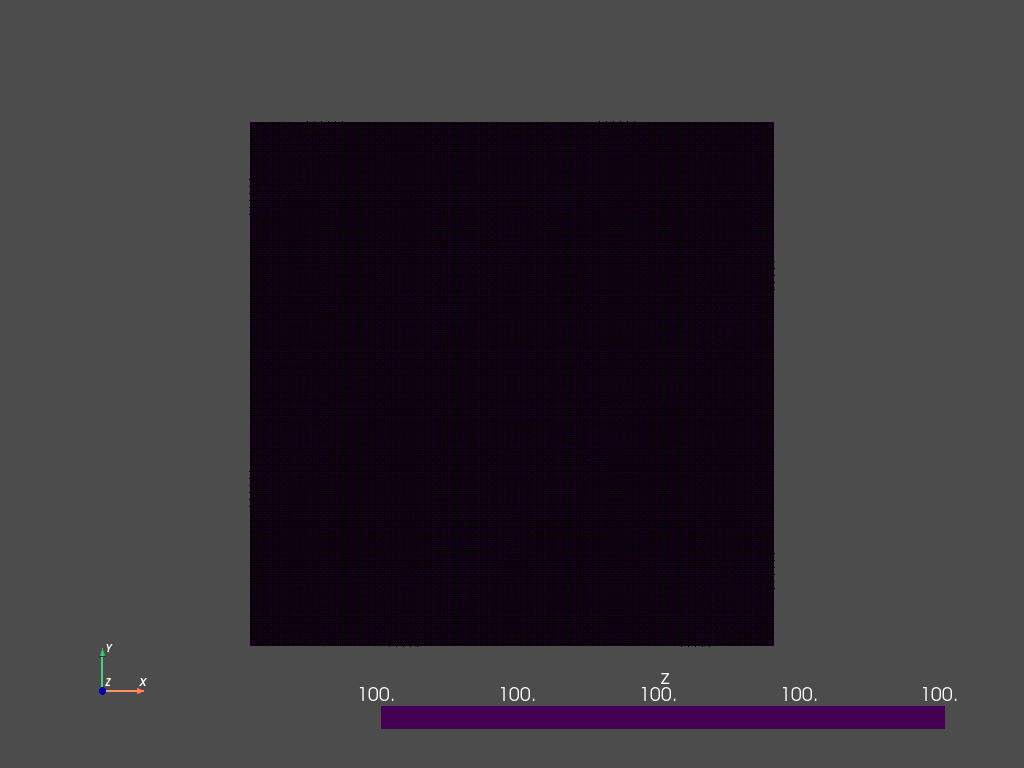

In [4]:
# create grid of coordinates
(easting, northing) = vd.grid_coordinates(
    region=buffer_region,
    spacing=spacing,
)

# surface = 100 * np.exp(-((easting - x_mid)**2 + (northing - y_mid)**2) / 1e10)

surface = vd.make_xarray_grid(
    (easting, northing), 
    # surface, 
    np.ones_like(easting)*100,
    data_names="z", dims=("y", "x")
).z

# fig = maps.plot_grd(
#     surface,
#     titles="Surface",
#     cbar_label="elevation (m)",
#     show_region=inner_region,
#     cpt_lims=[99,101],
# )

# fig.show()

surface.pyvista.plot(x="x", y="y", show_edges=True, cpos='xy', jupyter_backend='static')

## make prism layer

In [5]:
prisms = grids_to_prisms(
    surface,
    # surface.values.min(),
    np.ones_like(surface)*-200,
    density=2670,
)

print(f"Number of prisms: {len(vd.grid_to_table(prisms))}")

plots.show_prism_layers(
    [prisms],
    cmap="viridis",
    # color_by="density",
    color_by="thickness",
    clip_box=False,
    zscale=150,
    show_edges=True,
)

Number of prisms: 90601


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

## calculate forward gravity

In [6]:
observation_points = vd.grid_coordinates(
    inner_region,
    spacing=spacing,
    extra_coords=5e3,
)

  0%|          | 0/10201 [00:00<?, ?it/s]

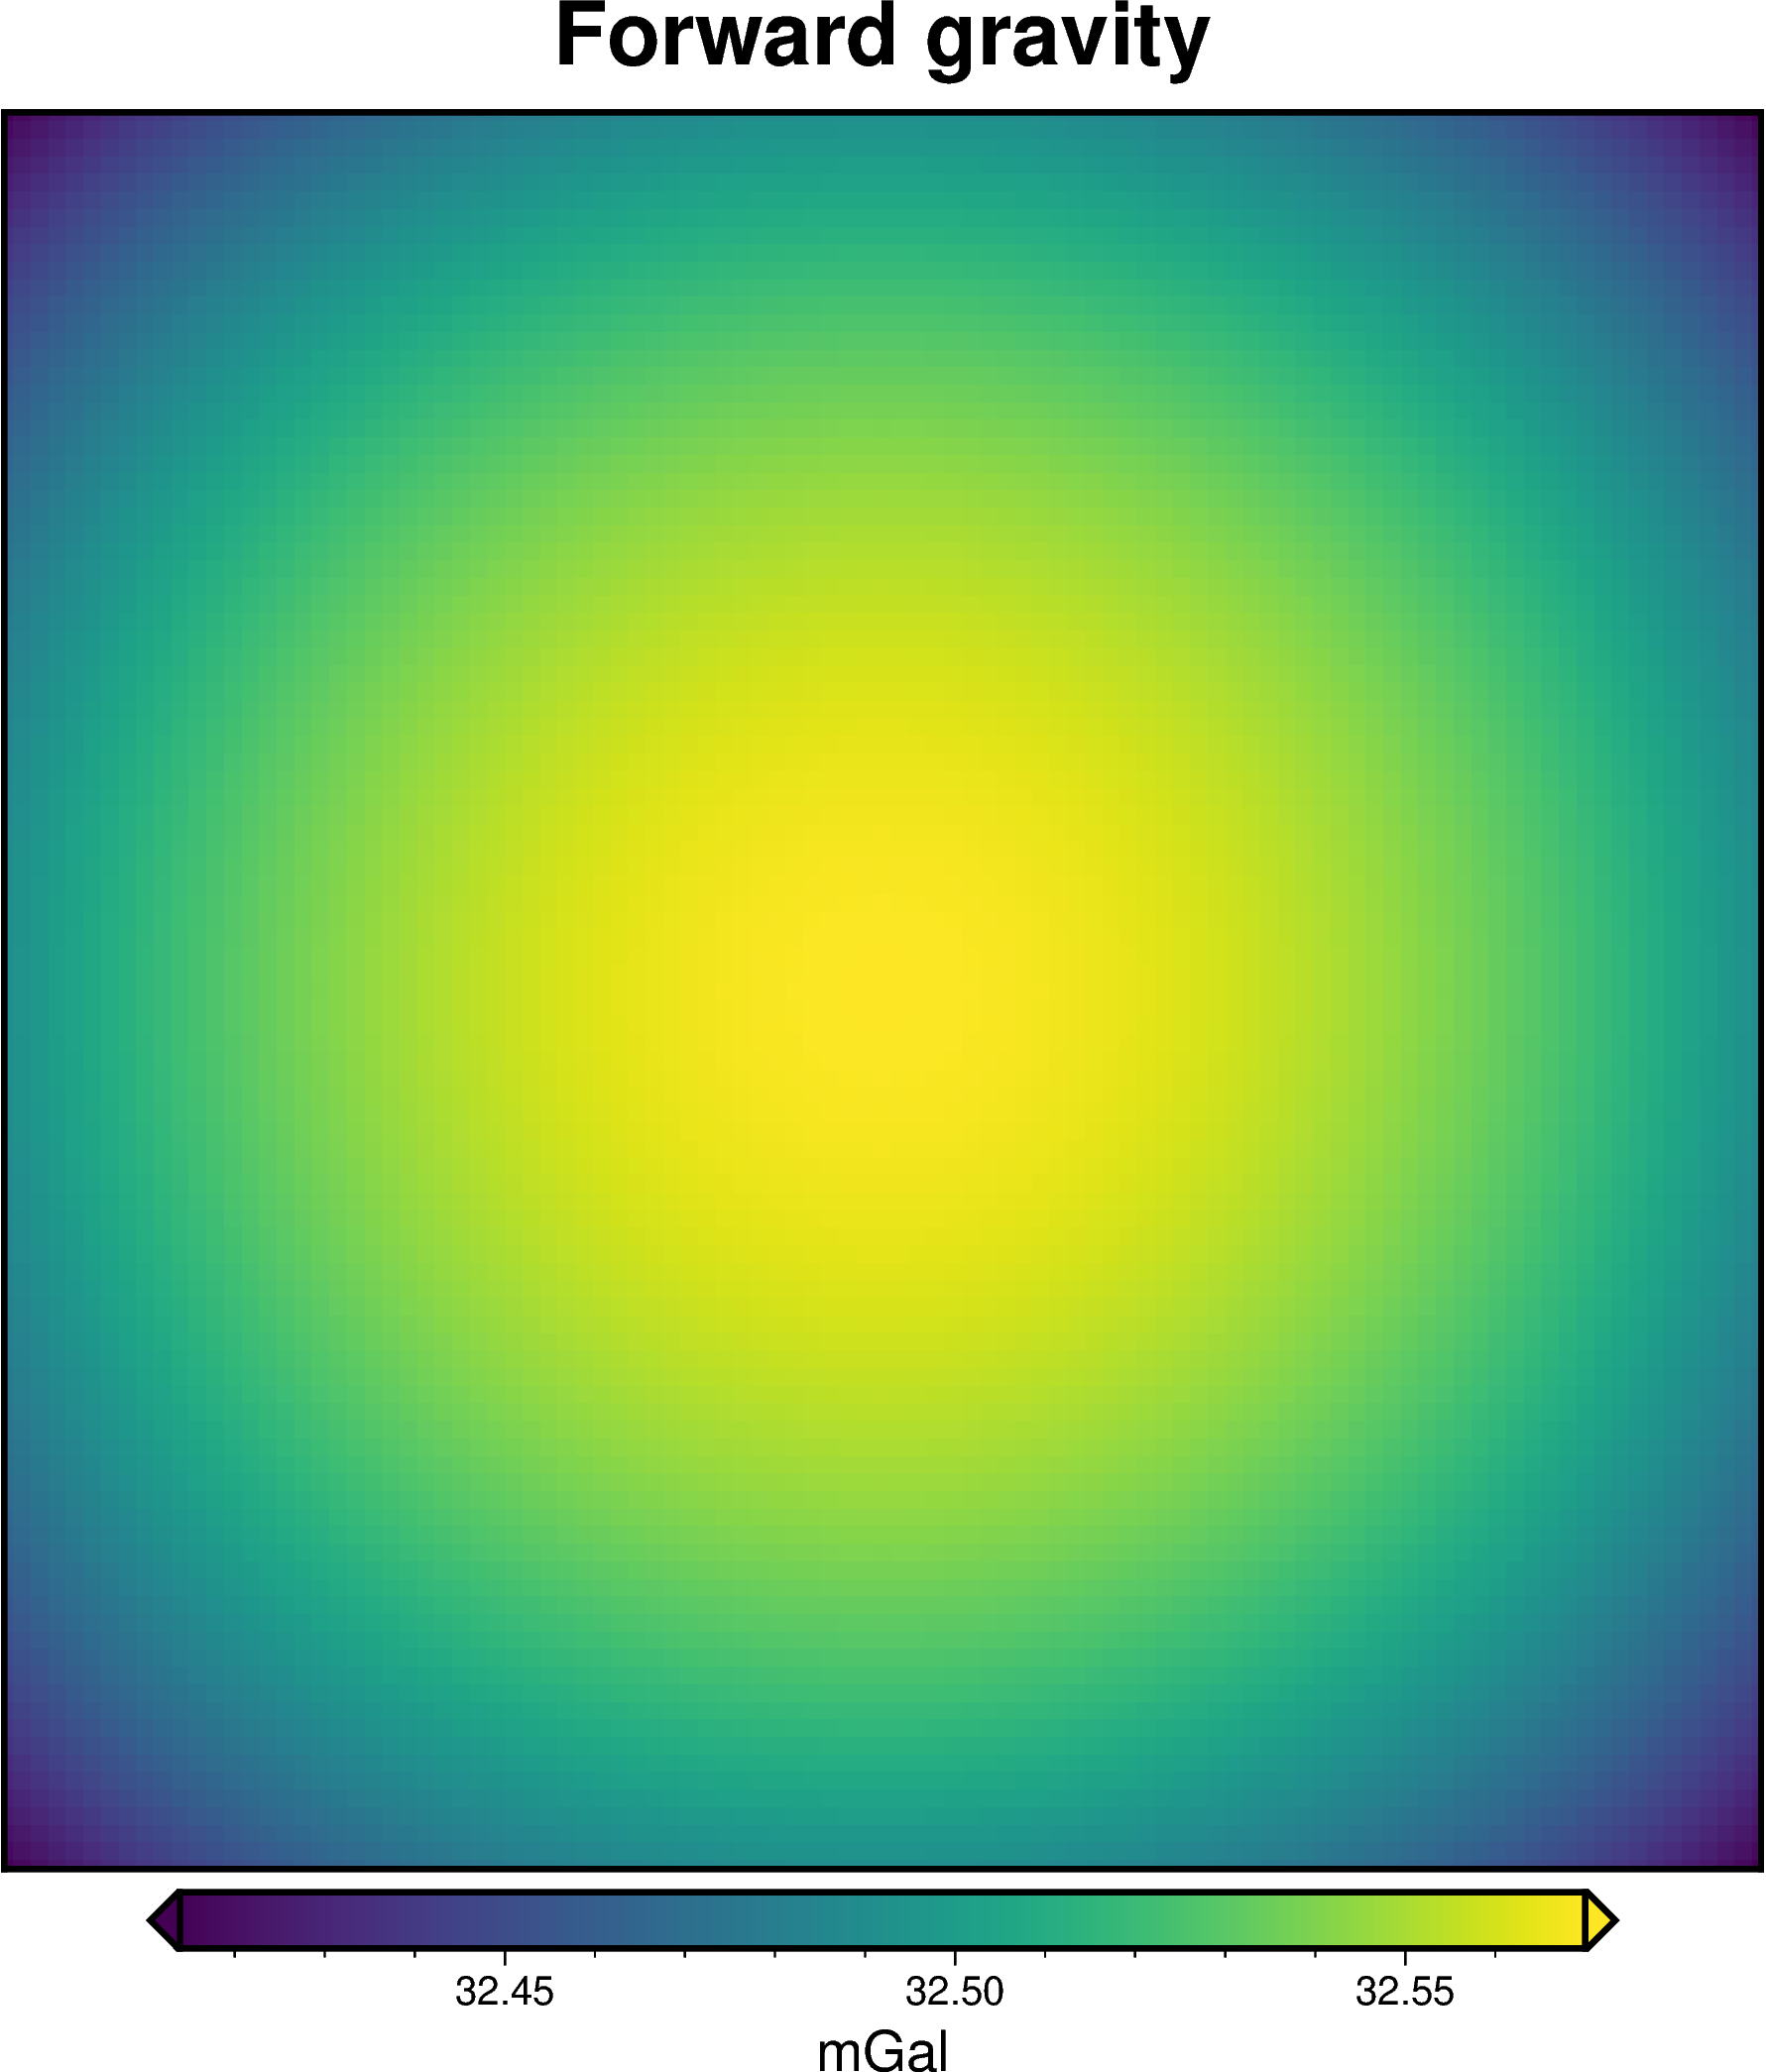

forward calculatione took 93.82018899917603 secs


In [43]:
constant_forward_grav, constant_time = forward_grav_of_prismlayer(
    [prisms],
    observation_points,
    plot=True,
    names=["Forward gravity"],
)
print(f"forward calculation took {constant_time} secs")

## profile

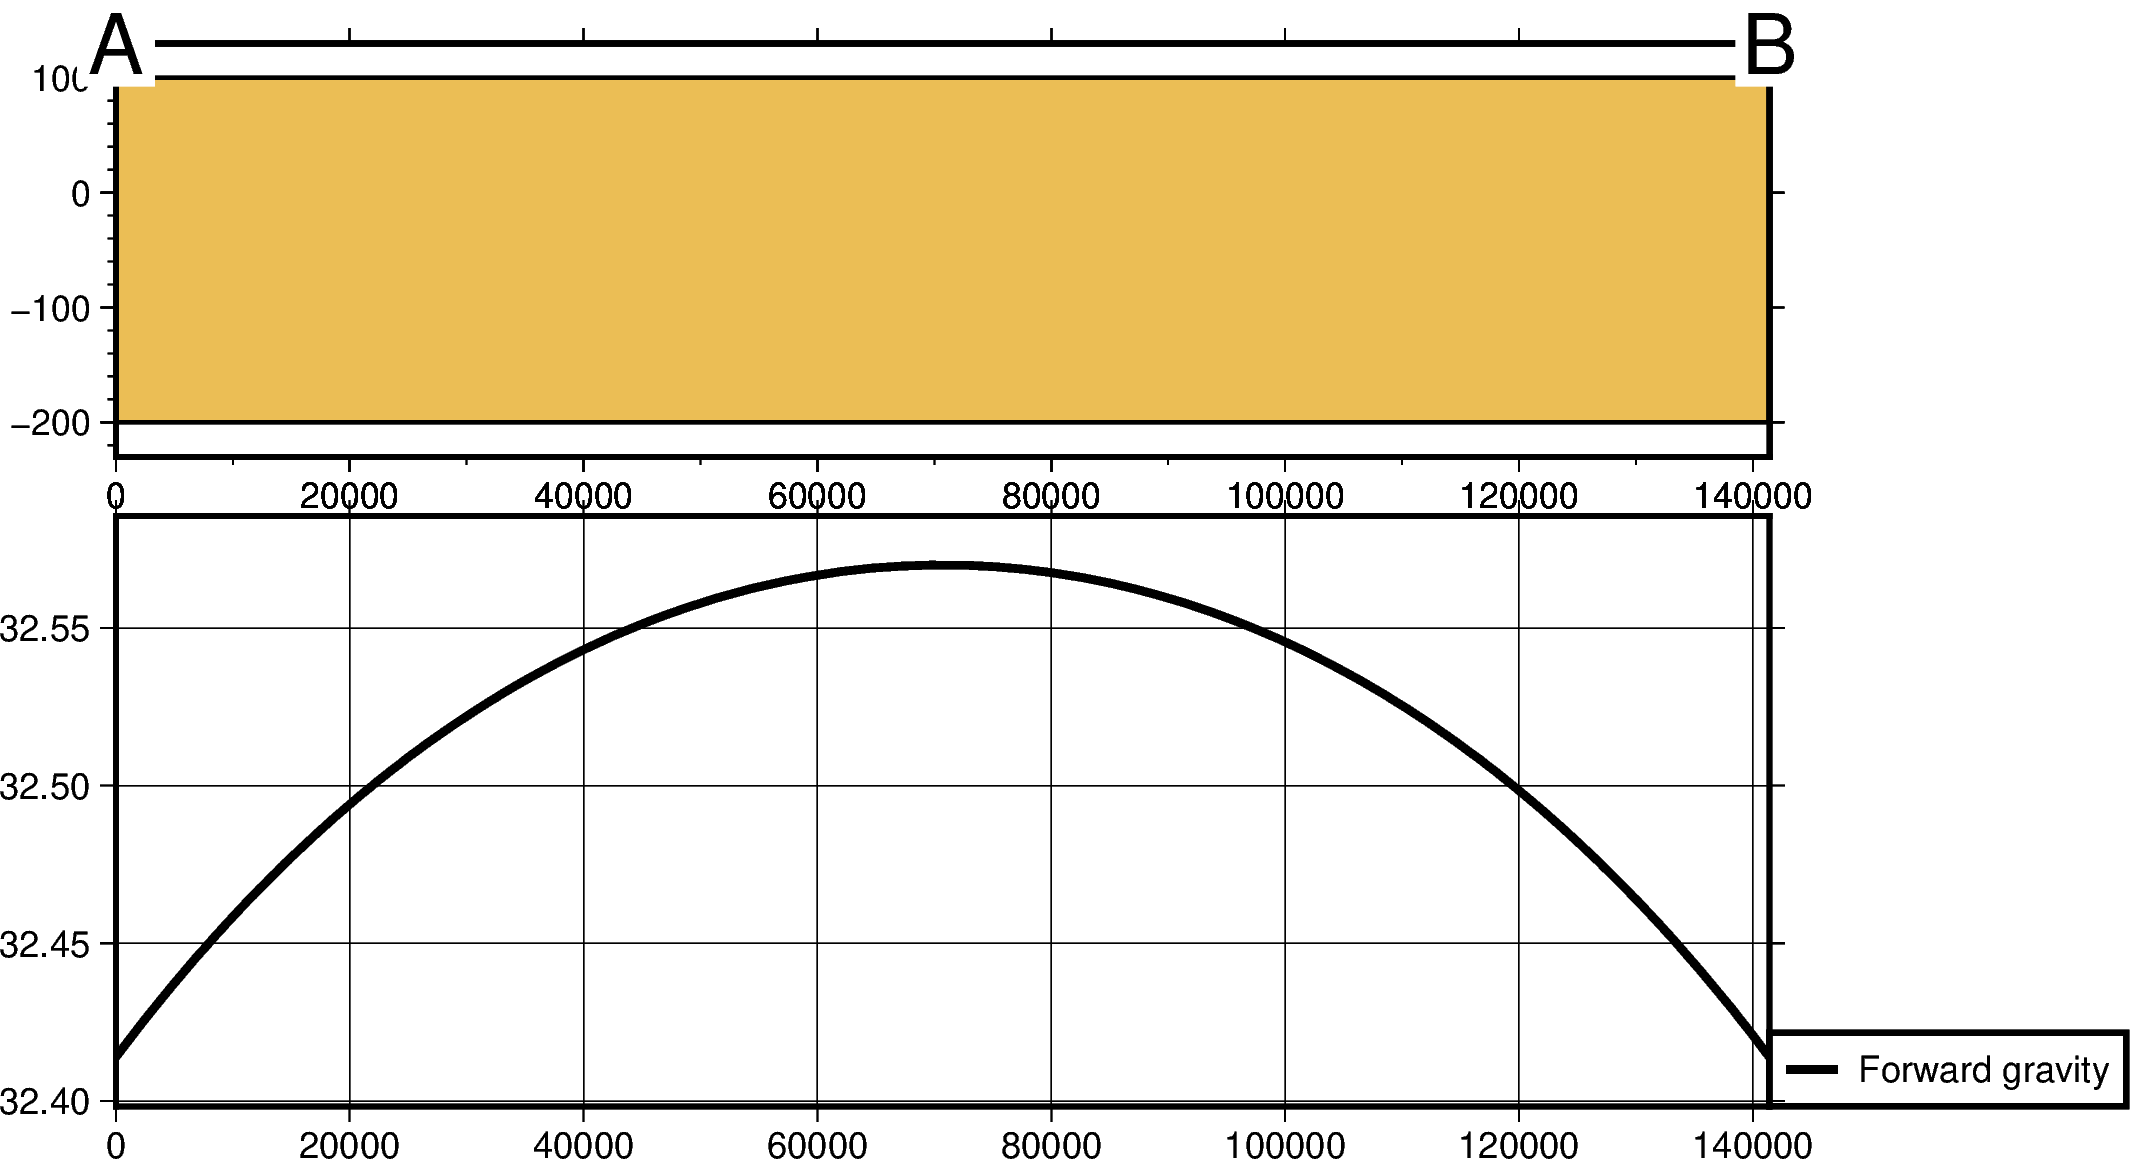

In [8]:
layers_dict = profile.make_data_dict(
    ["top", "bottom"],
    [prisms.top, prisms.bottom],
    ["lightbrown", "white"],
)
data_dict = profile.make_data_dict(
    ["Forward gravity"],
    [constant_forward_grav[0]],
    ["black"],
)

profile.plot_profile(
    "points",
    # start=(inner_region[0], y_mid),
    # stop=(inner_region[1], y_mid),
    start=(inner_region[0], inner_region[2]),
    stop=(inner_region[1], inner_region[3]),
    layers_dict=layers_dict,
    data_dict=data_dict,
    data_height=5,
    share_yaxis=True,
    # add_map=True,
    # map_buffer=0.7,
    # map_background=surface,
    # map_cmap="viridis",
    # coast=False,
    # inset=False,
    # gridlines=False,
)

## Compare resolutions

spacing larger than original, filtering and resampling


grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.


Number of prisms: 10201


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

  0%|          | 0/10201 [00:00<?, ?it/s]

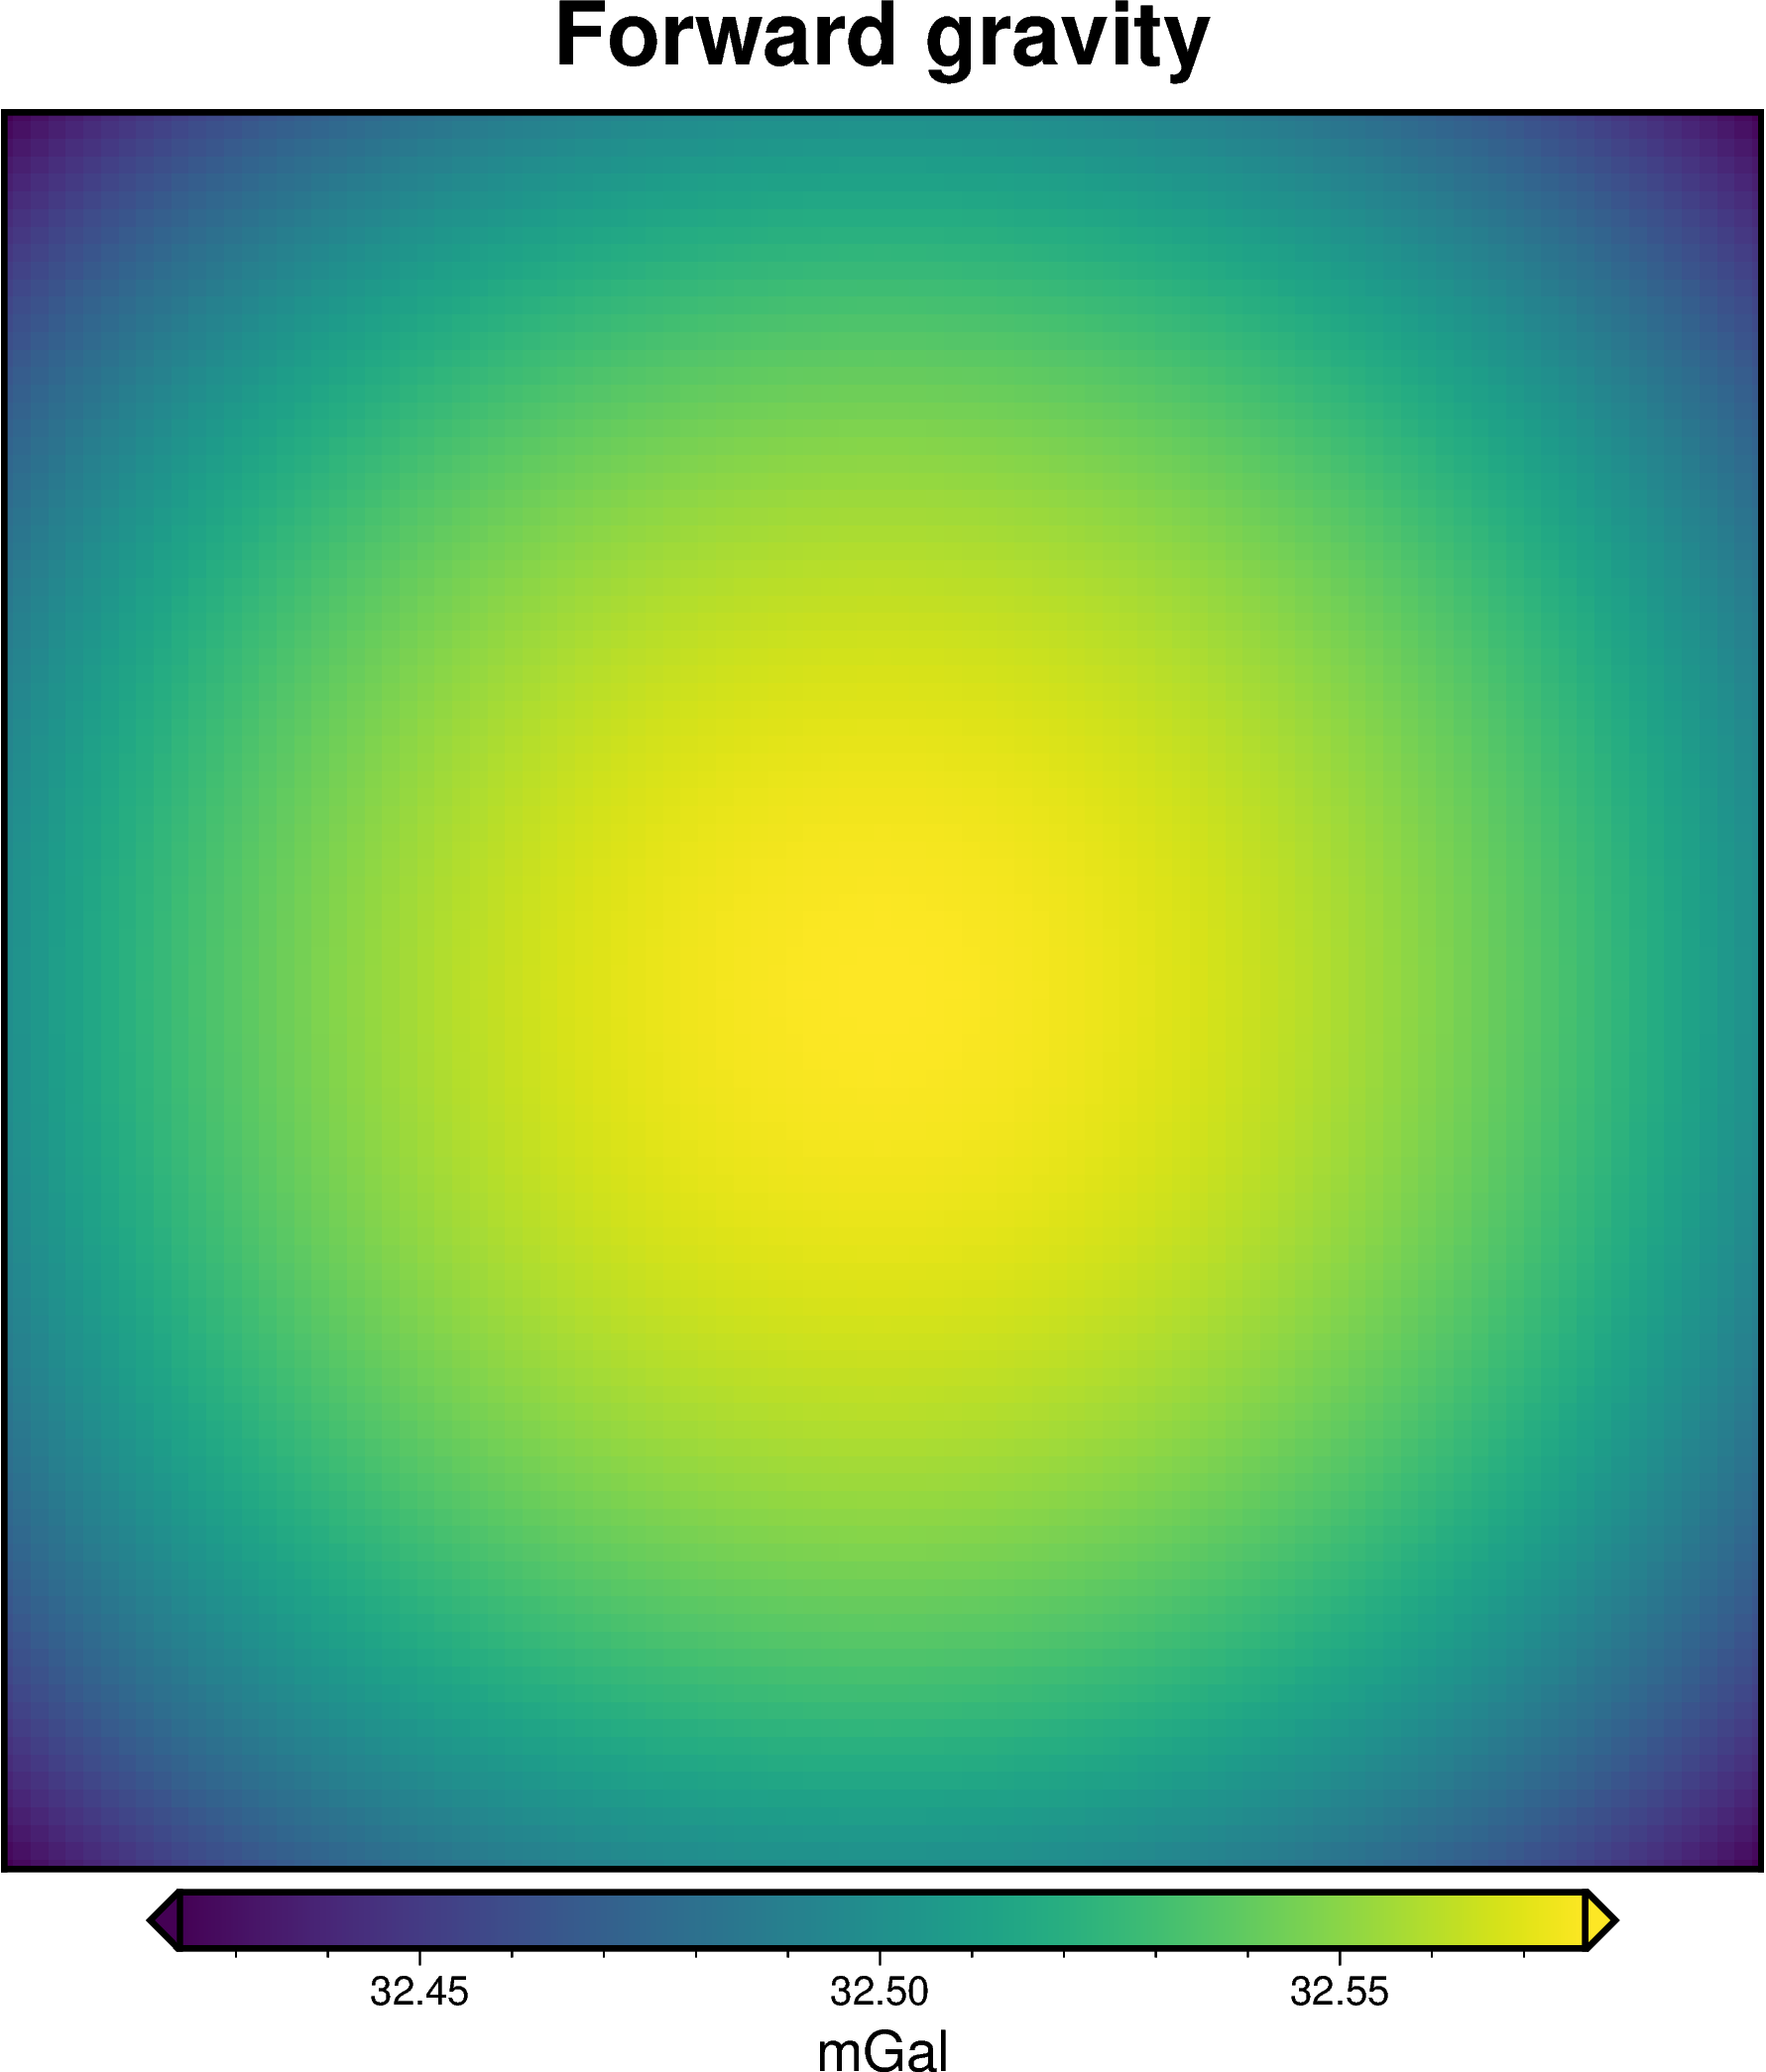

forward calculatione took 11.398219347000122 secs


In [42]:
surface_lowres = fetch.resample_grid(surface, spacing=spacing*3)

prisms_lowres = grids_to_prisms(
    surface_lowres,
    # surface.values.min(),
    np.ones_like(surface_lowres)*-200,
    density=2670,
)

print(f"Number of prisms: {len(vd.grid_to_table(prisms_lowres))}")

plots.show_prism_layers(
    [prisms_lowres],
    cmap="viridis",
    # color_by="density",
    color_by="thickness",
    clip_box=False,
    zscale=150,
    show_edges=True,
)

constant_forward_grav_lowres, constant_time = forward_grav_of_prismlayer(
    [prisms_lowres],
    observation_points,
    plot=True,
    names=["Forward gravity"],
)
print(f"forward calculation took {constant_time} secs")

returning original grid
returning original grid
returning original grid
returning original grid
returning original grid


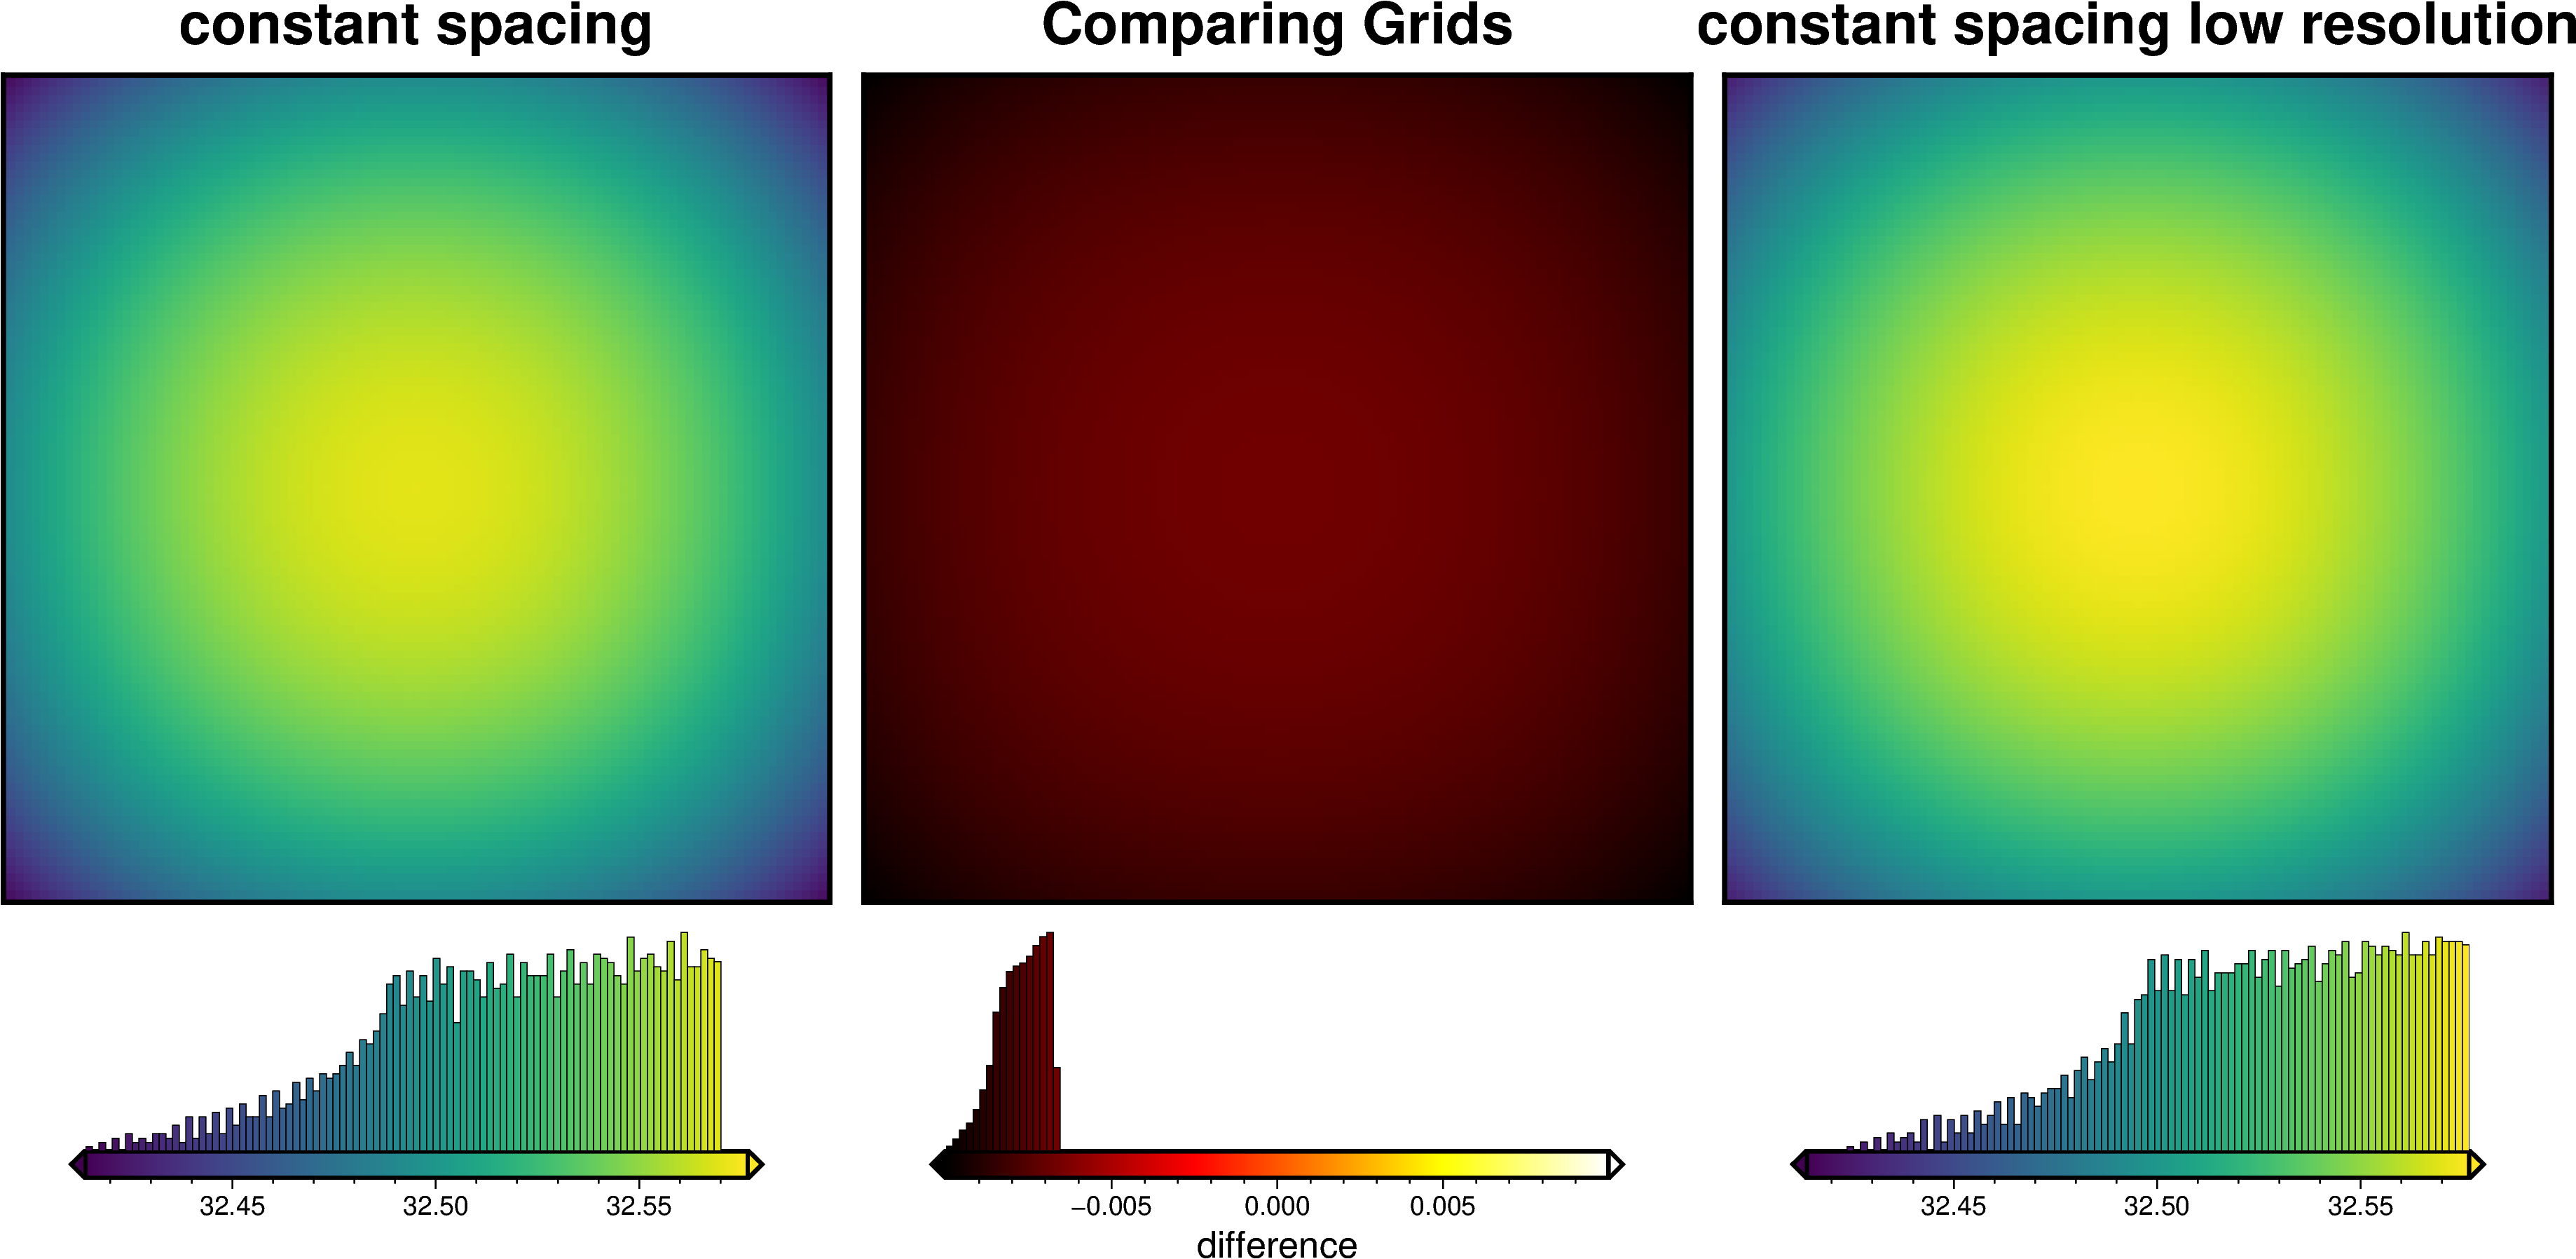

In [52]:
grids = utils.grd_compare(
    constant_forward_grav[0],
    constant_forward_grav_lowres[0],
    plot=True,
    inset=False,
    grid1_name="constant spacing",
    grid2_name="constant spacing low resolution",
    show_region=inner_region,
    diff_cmap="hot",
    hist=True,
)

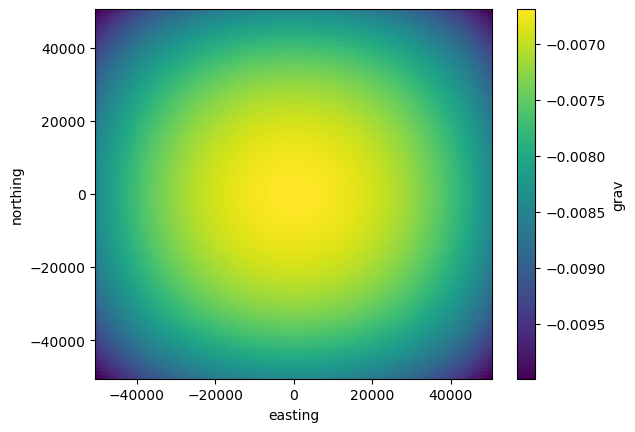

In [51]:
grids[0].plot()

# 1 expanding buffer zone

## make surface grid (inner and buffer)

returning grid with new region and/or registration, same spacing


c:\Users\matthewt\AppData\Local\miniforge3\envs\RIS_gravity_inversion\lib\site-packages\xarray\backends\plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


spacing larger than original, filtering and resampling


grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.


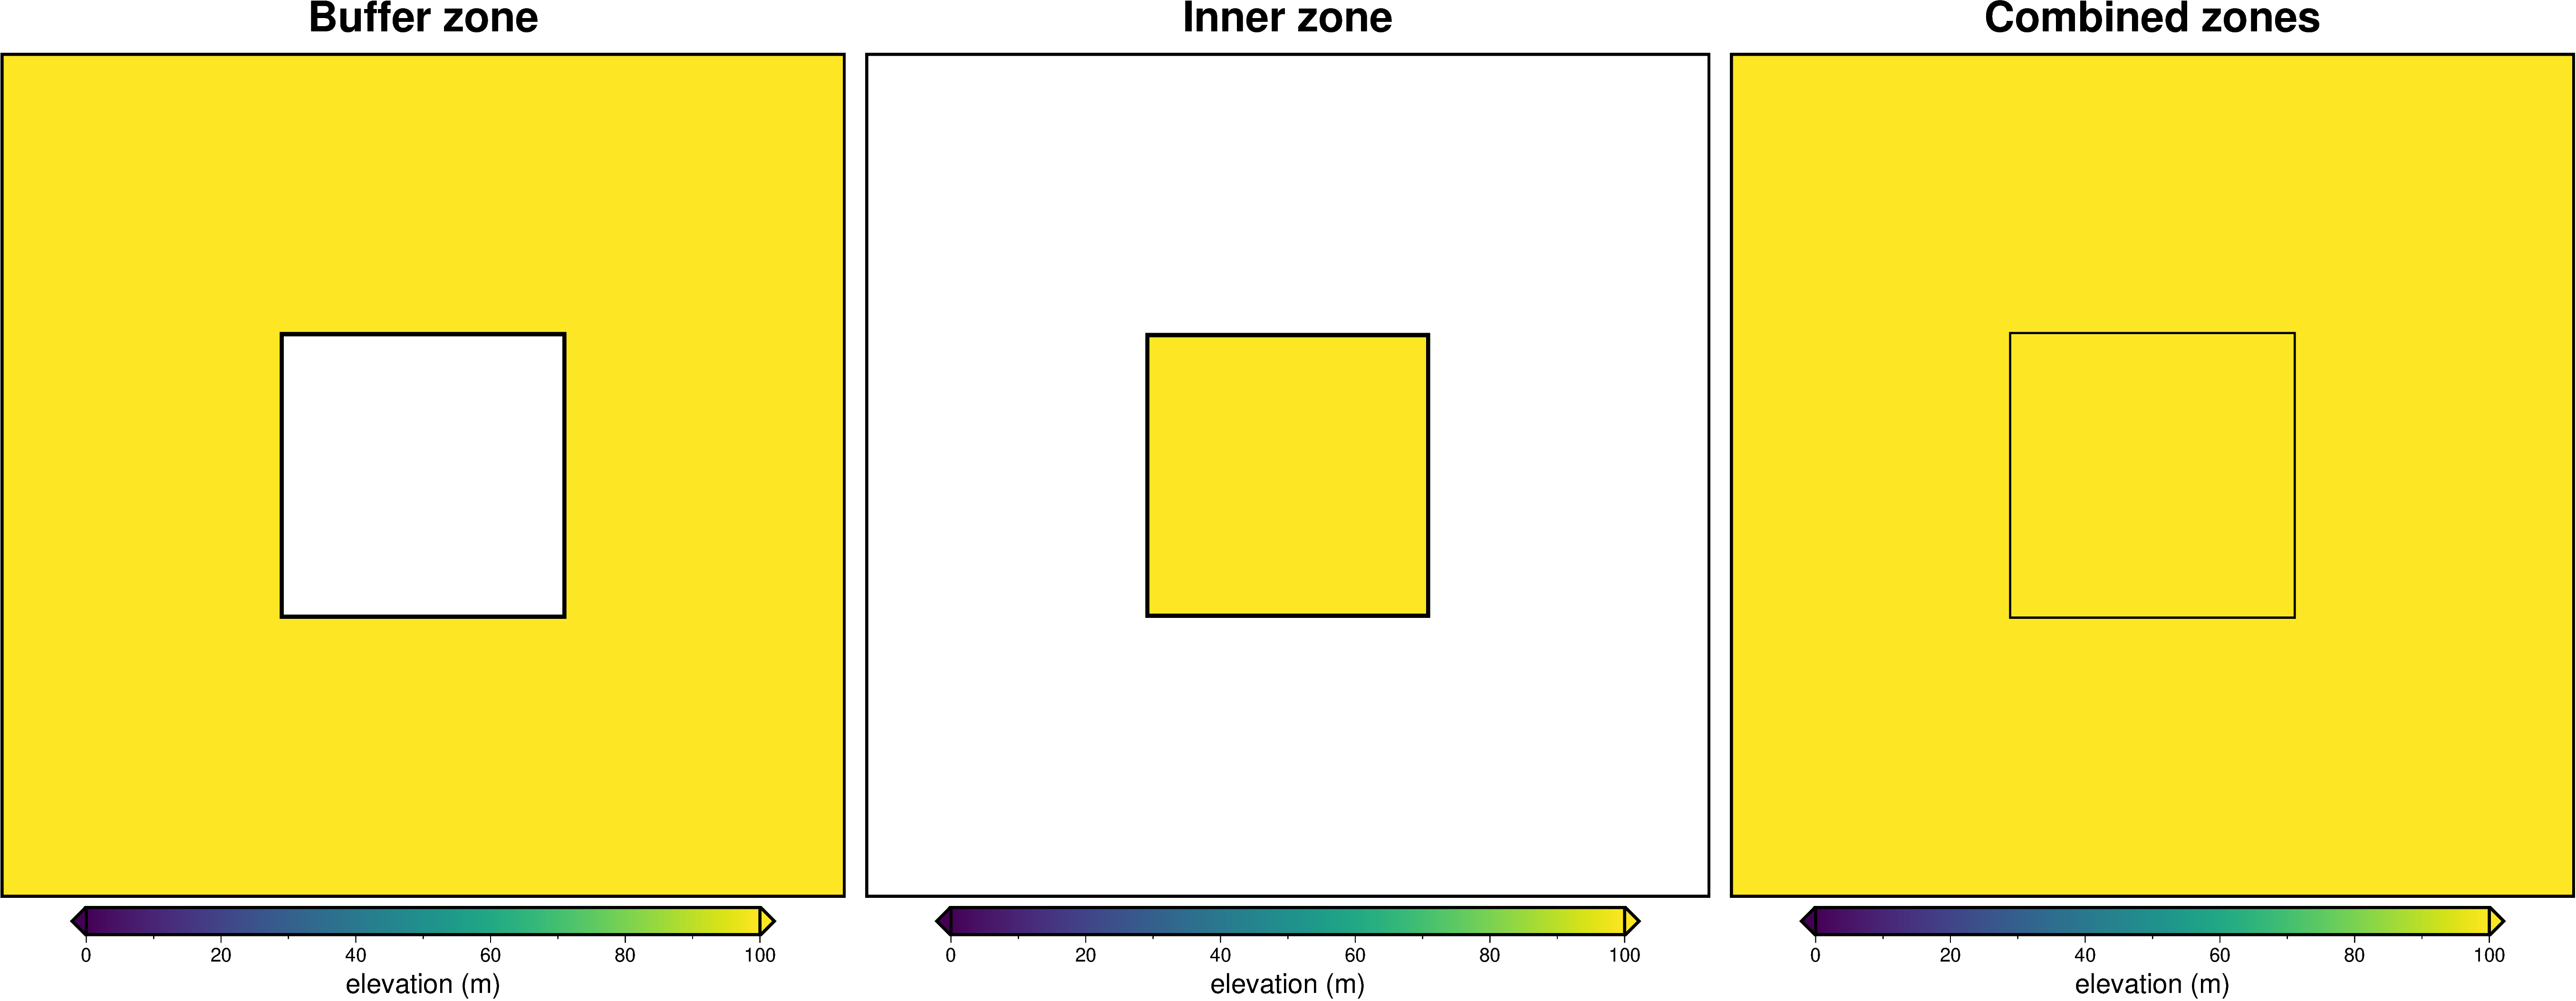

In [9]:
inner_surface = fetch.resample_grid(
    surface, 
    region=utils.alter_region(
        inner_region, 
        # zoom=-spacing,
        )[0], 
    registration='p')

buffer_spacing = int(spacing*2)

buffer_surface = fetch.resample_grid(
    surface, 
    spacing=buffer_spacing,
    registration='p')

buffer_surface = buffer_surface.where(
    (buffer_surface.x < inner_region[0]) |  
    (buffer_surface.x > inner_region[1]) |
    (buffer_surface.y < inner_region[2]) |
    (buffer_surface.y > inner_region[3])
    )

# plot buffer zone
fig = maps.plot_grd(
    buffer_surface,
    cpt_lims=[0,100],
    title="Buffer zone",
    cbar_label="elevation (m)",
    show_region=inner_region,
)

# plot inner zone
fig = maps.plot_grd(
    inner_surface,
    region=buffer_region,
    cpt_lims=[0,100],
    title="Inner zone",
    cbar_label="elevation (m)",
    show_region=inner_region,
    fig=fig,
    origin_shift='xshift',
)

# plot both inner and buffer
fig = maps.plot_grd(
    buffer_surface,
    cpt_lims=[0,100],
    title="Combined zones",
    cbar_label="elevation (m)",
    show_region=inner_region,
    fig=fig,
    origin_shift='xshift',
)
fig.grdimage(inner_surface, cmap=True, transparency=0)

fig.show()

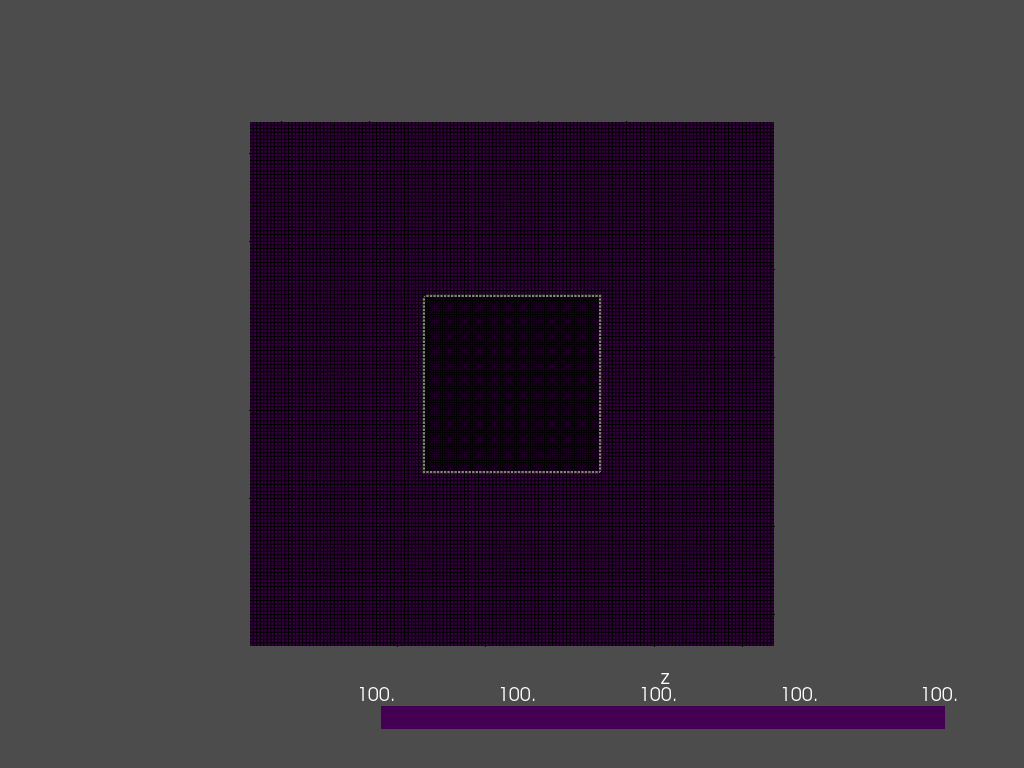

In [10]:
p = pv.Plotter()

p.add_mesh(buffer_surface.pyvista.mesh(x="x", y="y"), show_edges=True)
p.add_mesh(inner_surface.pyvista.mesh(x="x", y="y"), show_edges=True)
p.show(cpos='xy', jupyter_backend='static')

## make prism layer

In [27]:
inner_prisms = grids_to_prisms(
    inner_surface,
    np.ones_like(inner_surface)*-200,
    density=2670,
)

buffer_prisms = grids_to_prisms(
    buffer_surface,
    np.ones_like(buffer_surface)*-200,
    density=2670,
)

num = len(vd.grid_to_table(inner_prisms)) + \
    len(vd.grid_to_table(buffer1_prisms)) + \
    len(vd.grid_to_table(buffer2_prisms))

print(f"Number of prisms: {num}")

plots.show_prism_layers(
    [inner_prisms, buffer_prisms],
    cmap="viridis",
    # color_by="density",
    color_by="thickness",
    clip_box=False,
    zscale=150,
)

Number of prisms: 25476


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [12]:
# just inner prisms
plots.show_prism_layers(
    [inner_prisms],
    cmap="viridis",
    # color_by="density",
    color_by="thickness",
    clip_box=False,
    zscale=150,
)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [13]:
# just buffer prisms
plots.show_prism_layers(
    [buffer_prisms],
    cmap="viridis",
    # color_by="density",
    color_by="thickness",
    clip_box=False,
    zscale=150,
)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

## calculate forward gravity

  0%|          | 0/10201 [00:00<?, ?it/s]

  0%|          | 0/10201 [00:00<?, ?it/s]

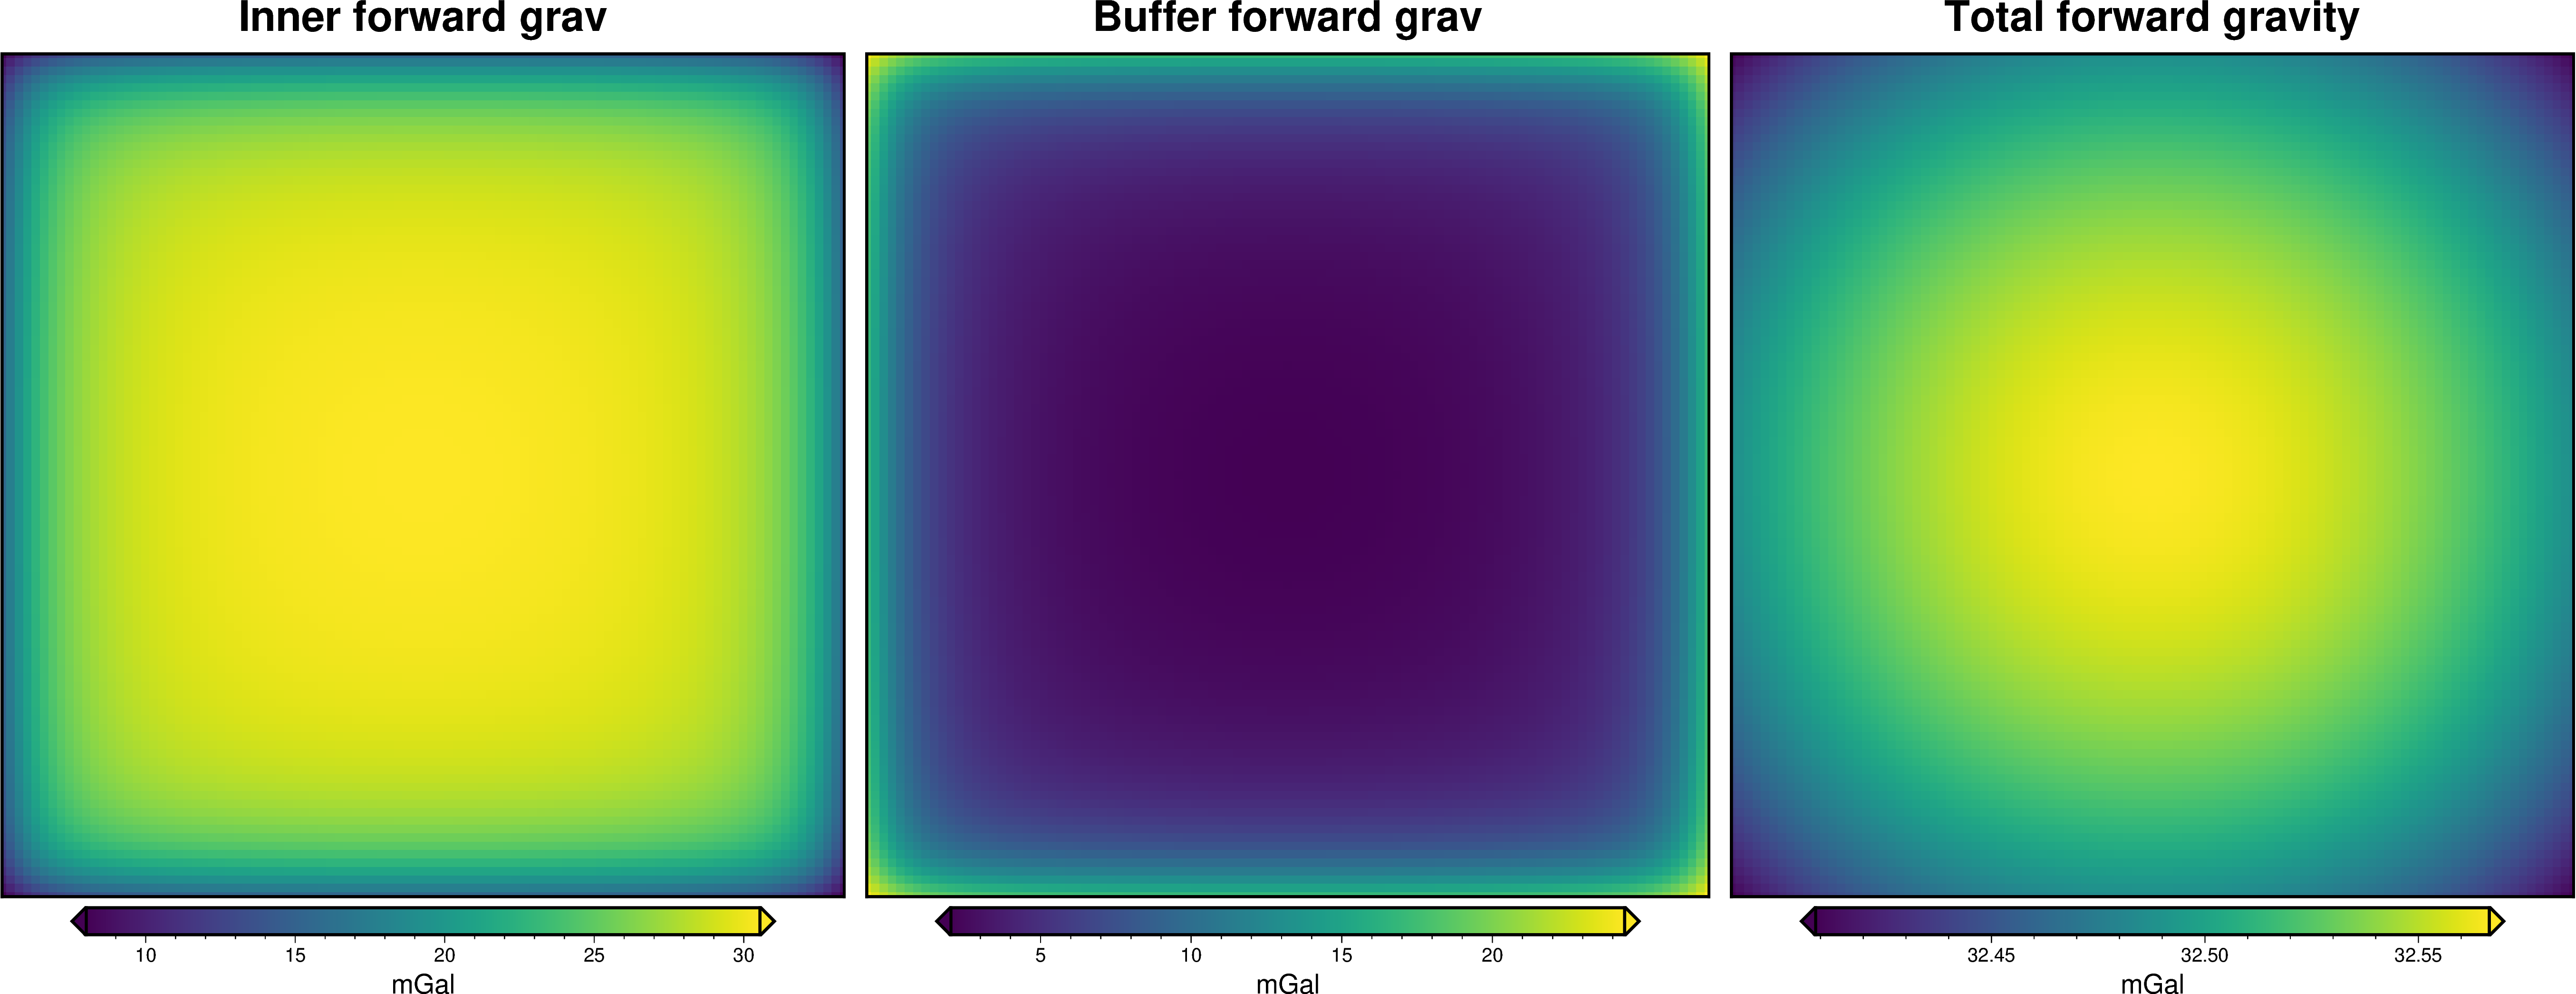

forward calculation took 34.41593146324158 secs


In [14]:
single_buffer_forward_grav, single_buffer_time = forward_grav_of_prismlayer(
    [inner_prisms, buffer_prisms],
    observation_points,
    plot=True,
    names=["Inner forward grav", "Buffer forward grav"],
)
print(f"forward calculation took {single_buffer_time} secs")

## profile

grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


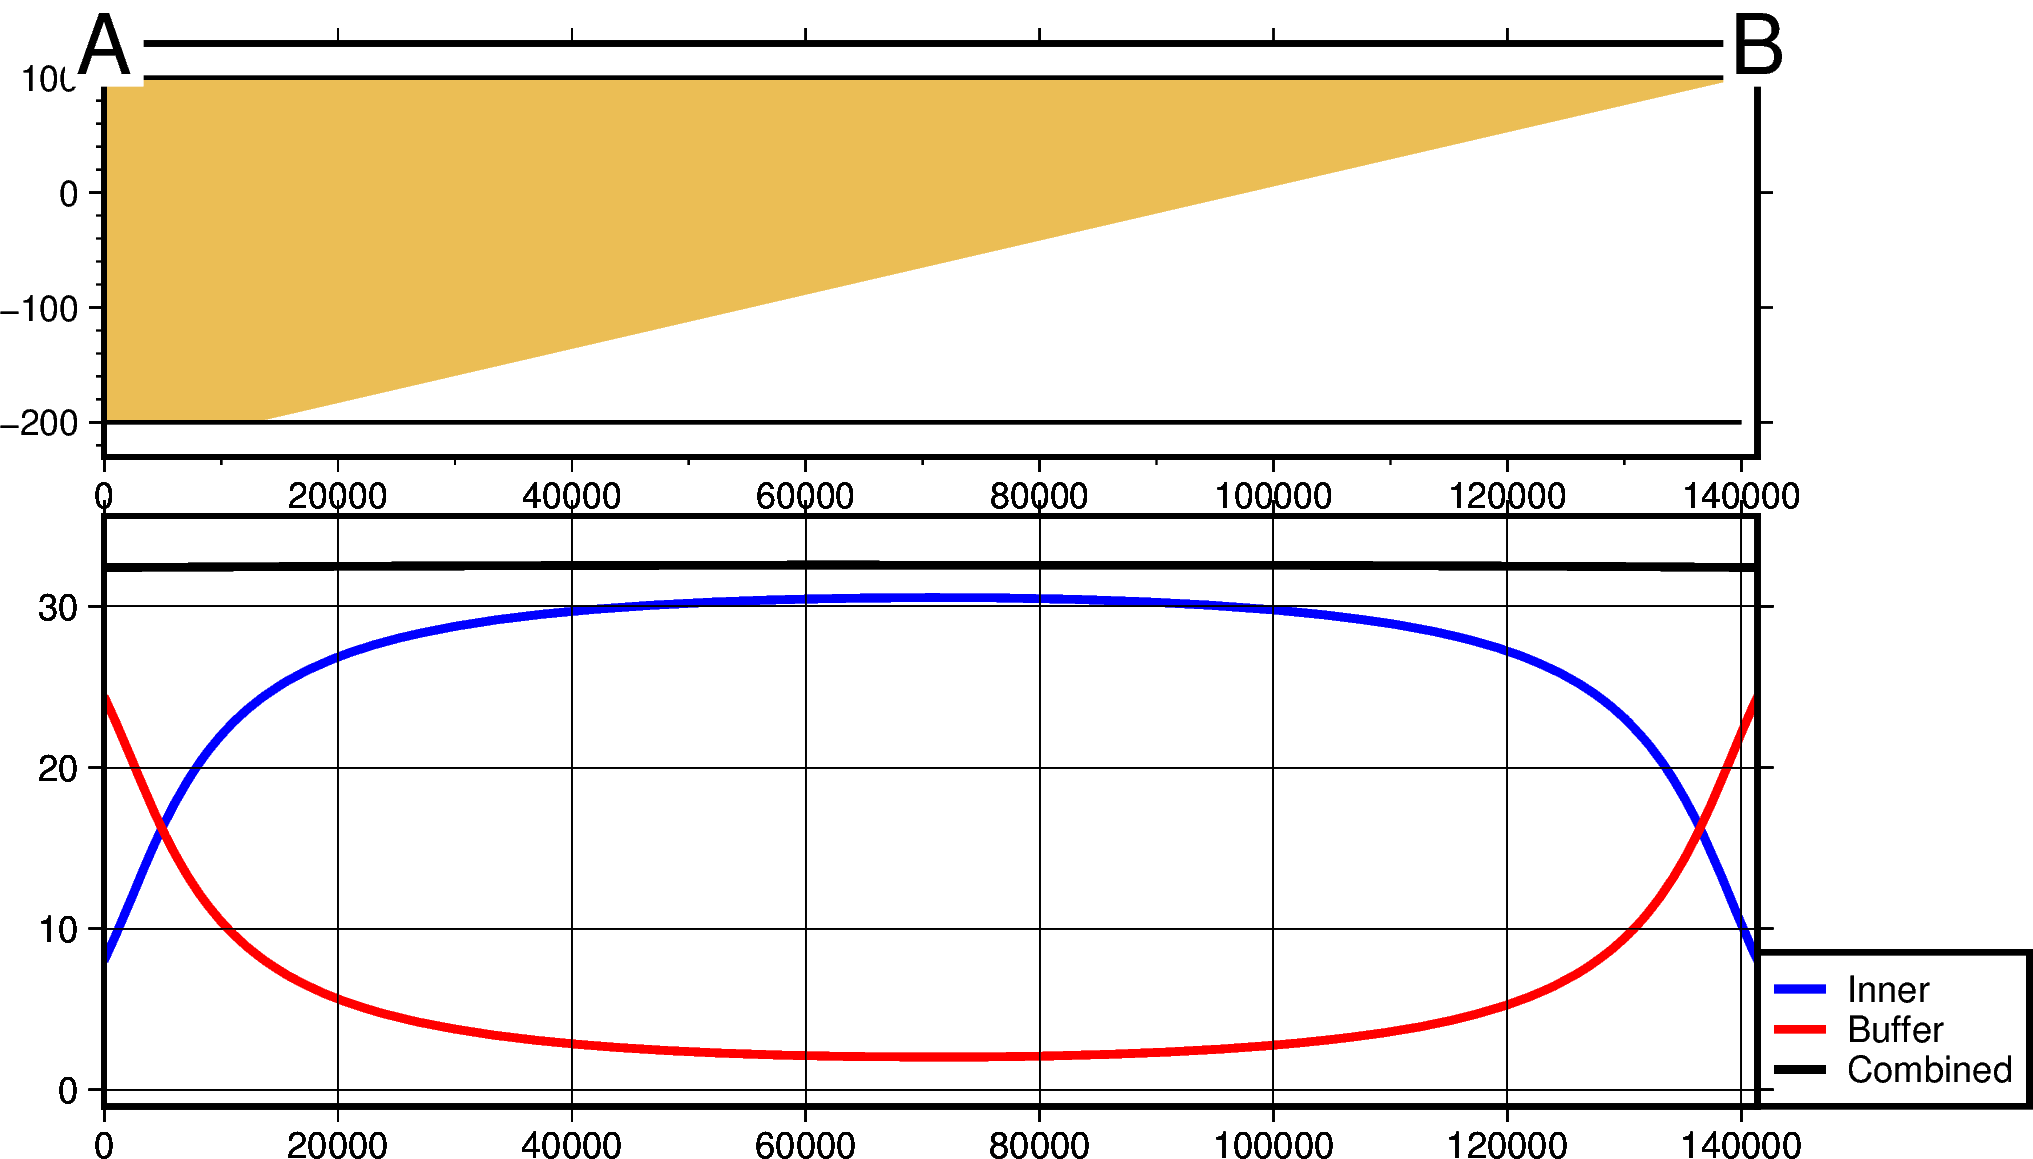

In [15]:
layers_dict = profile.make_data_dict(
    ["top", "bottom"],
    [inner_prisms.top, inner_prisms.bottom],
    ["lightbrown", "white"],
)
data_dict = profile.make_data_dict(
    ["Inner", "Buffer", "Combined"],
    [single_buffer_forward_grav[0], 
    single_buffer_forward_grav[1], 
    single_buffer_forward_grav[2]],
    ["blue", "red", "black"],
)

profile.plot_profile(
    "points",
    # start=(inner_region[0], y_mid),
    # stop=(inner_region[1], y_mid),
    start=(inner_region[0], inner_region[2]),
    stop=(inner_region[1], inner_region[3]),
    layers_dict=layers_dict,
    data_dict=data_dict,
    data_height=5,
    share_yaxis=True,
    # add_map=True,
    # map_buffer=0.7,
    # map_background=surface,
    # map_cmap="viridis",
    # coast=False,
    # inset=False,
    # gridlines=False,
)

# 2 expanding buffer zones

## define regions

In [16]:
buffer1_region = utils.alter_region(inner_region, buffer=buffer_zoom/2)[1]
buffer2_region = utils.alter_region(buffer1_region, buffer=buffer_zoom/2)[1]

print(inner_region)
print(buffer1_region)
print(buffer2_region)

[-50000.0, 50000.0, -50000.0, 50000.0]
[-100000, 100000, -100000, 100000]
[-150000, 150000, -150000, 150000]


## make surface grids

spacing larger than original, filtering and resampling


grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.


spacing larger than original, filtering and resampling


grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.


returning grid with new region and/or registration, same spacing


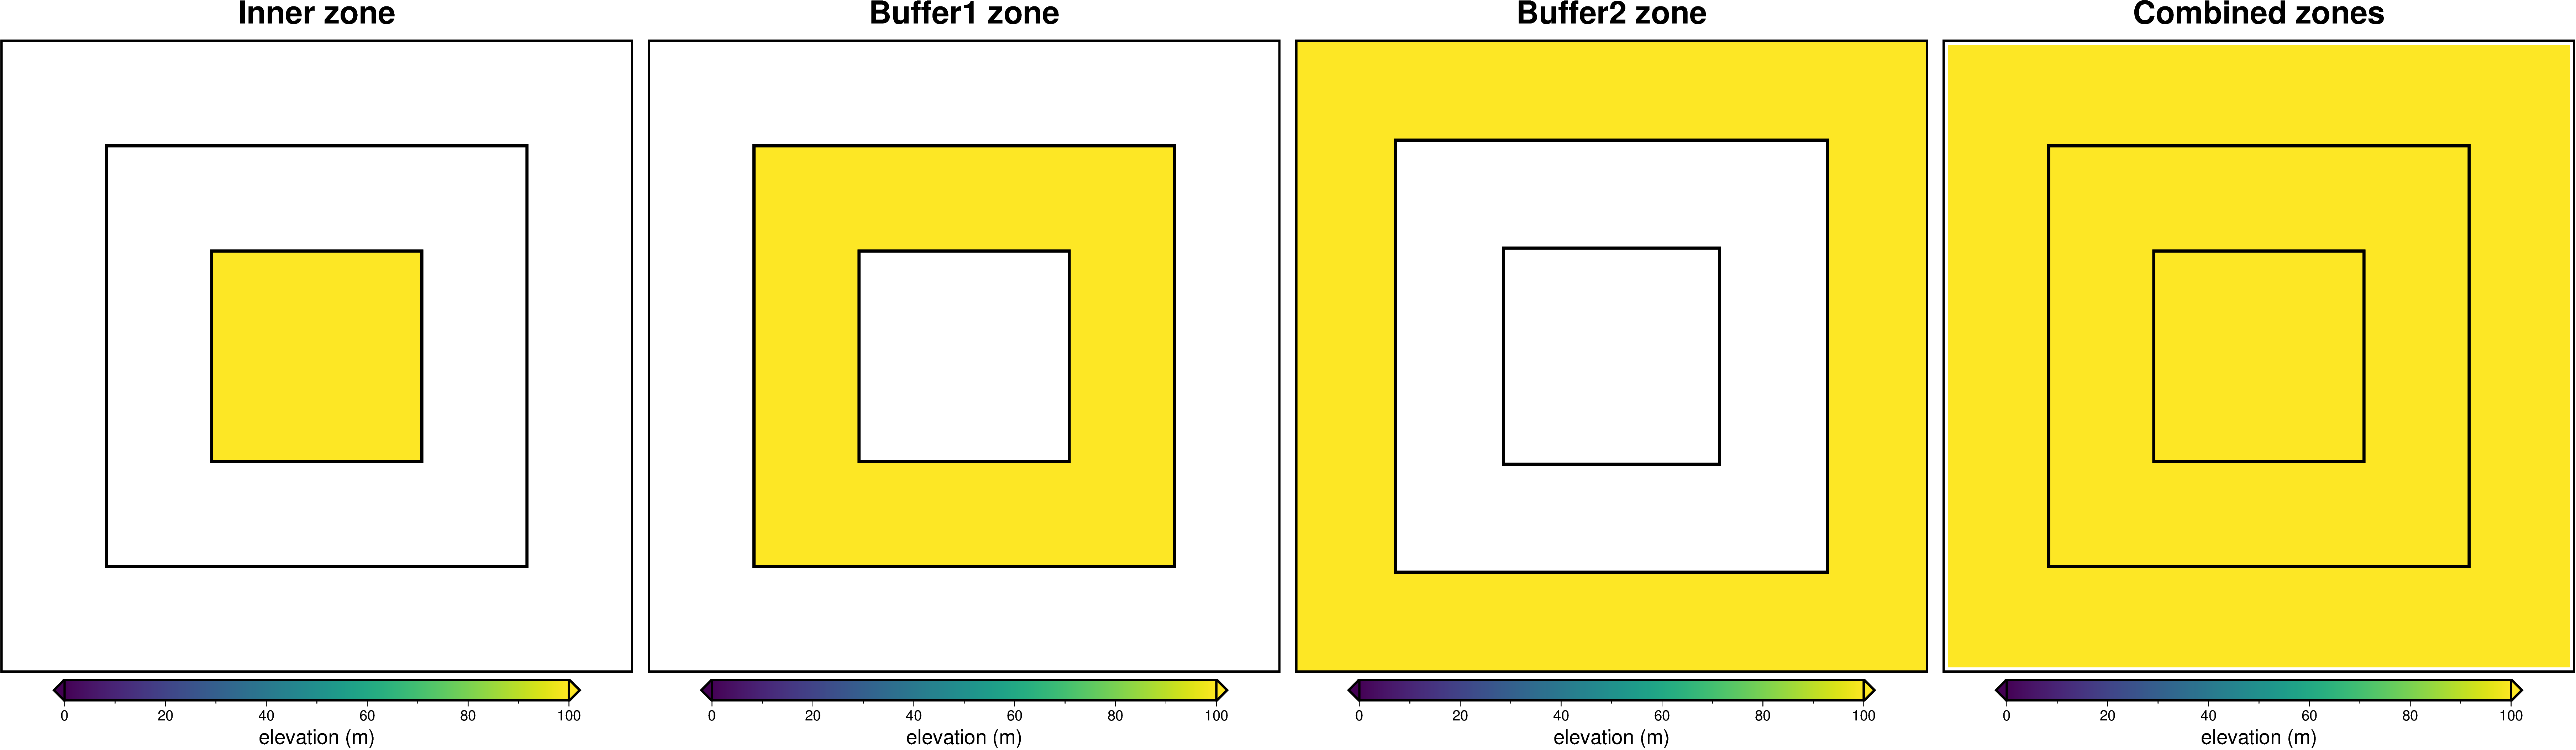

In [17]:
buffer1_spacing = spacing*2
buffer2_spacing = buffer1_spacing*2

buffer1_surface = fetch.resample_grid(
    surface, 
    spacing=buffer1_spacing,
    registration='p')

buffer2_surface = fetch.resample_grid(
    surface, 
    spacing=buffer2_spacing,
    registration='p')

# mask outside buffer1
buffer1_surface = fetch.resample_grid(buffer1_surface, region=buffer1_region)

# mask inner region
buffer1_surface = buffer1_surface.where(
    (buffer1_surface.x < inner_region[0]) |  
    (buffer1_surface.x > inner_region[1]) |
    (buffer1_surface.y < inner_region[2]) |
    (buffer1_surface.y > inner_region[3]) 
)

# mask inside buffer1 region
buffer2_surface = buffer2_surface.where(
    (buffer2_surface.x < buffer1_region[0]) |  
    (buffer2_surface.x > buffer1_region[1]) |
    (buffer2_surface.y < buffer1_region[2]) |
    (buffer2_surface.y > buffer1_region[3])
    )

# plot inner zone zone
fig = maps.plot_grd(
    inner_surface,
    region=buffer_region,
    cpt_lims=[0,100],
    title="Inner zone",
    cbar_label="elevation (m)",
)
maps.add_box(fig, inner_region)
maps.add_box(fig, buffer1_region)

# plot buffer1 zone
fig = maps.plot_grd(
    buffer1_surface,
    region=buffer_region,
    cpt_lims=[0,100],
    title="Buffer1 zone",
    cbar_label="elevation (m)",
    fig=fig,
    origin_shift='xshift',
)
maps.add_box(fig, inner_region)
maps.add_box(fig, buffer1_region)

# plot both inner and buffer
fig = maps.plot_grd(
    buffer2_surface,
    cpt_lims=[0,100],
    title="Buffer2 zone",
    cbar_label="elevation (m)",
    fig=fig,
    origin_shift='xshift',
)
maps.add_box(fig, inner_region)
maps.add_box(fig, buffer1_region)

# plot 3 regions
fig = maps.plot_grd(
    buffer2_surface,
    region=buffer_region,
    cpt_lims=[0,100],
    title="Combined zones",
    cbar_label="elevation (m)",
    fig=fig,
    origin_shift='xshift',
)
fig.grdimage(buffer1_surface, cmap=True, transparency=0)
fig.grdimage(inner_surface, cmap=True, transparency=0)
maps.add_box(fig, inner_region)
maps.add_box(fig, buffer1_region)

fig.show()

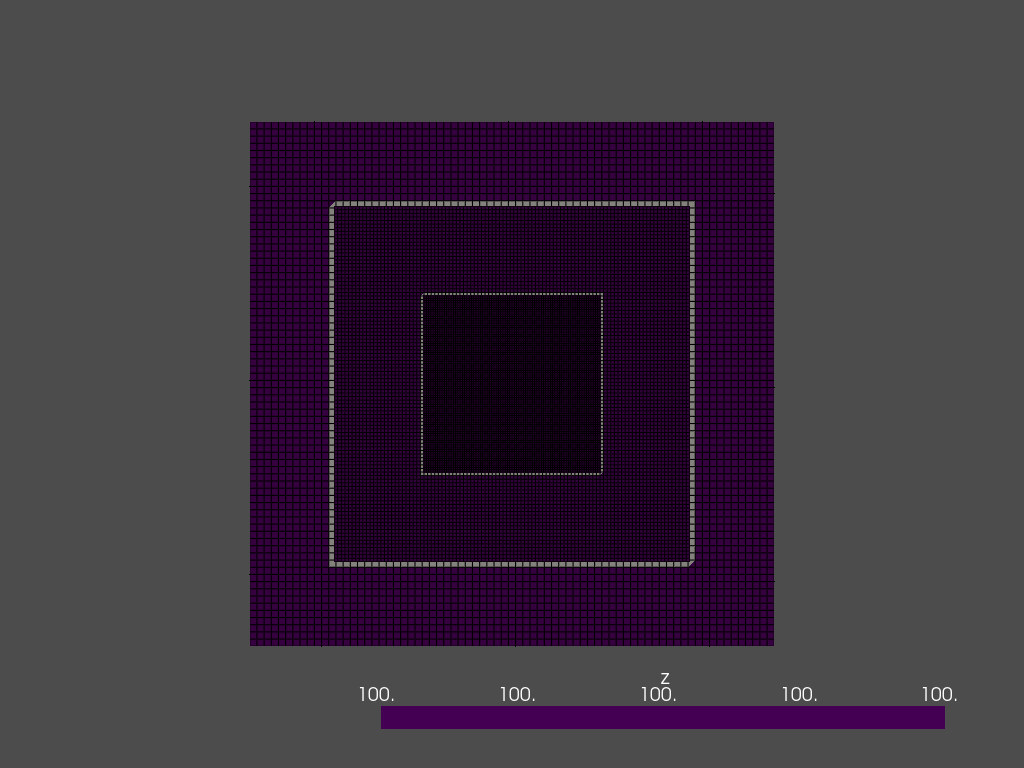

In [18]:
p = pv.Plotter()

p.add_mesh(buffer2_surface.pyvista.mesh(x="x", y="y"), show_edges=True)
p.add_mesh(buffer1_surface.pyvista.mesh(x="x", y="y"), show_edges=True)
p.add_mesh(inner_surface.pyvista.mesh(x="x", y="y"), show_edges=True)

p.show(cpos='xy', jupyter_backend='static')

## make prism layer

In [19]:
inner_prisms = grids_to_prisms(
    inner_surface,
    np.ones_like(inner_surface)*-200,
    density=2670,
)

buffer1_prisms = grids_to_prisms(
    buffer1_surface,
    np.ones_like(buffer1_surface)*-200,
    density=2670,
)

buffer2_prisms = grids_to_prisms(
    buffer2_surface,
    np.ones_like(buffer2_surface)*-200,
    density=2670,
)

num = len(vd.grid_to_table(inner_prisms)) + \
    len(vd.grid_to_table(buffer1_prisms)) + \
    len(vd.grid_to_table(buffer2_prisms))

print(f"Number of prisms: {num}")

plots.show_prism_layers(
    [inner_prisms, buffer1_prisms, buffer2_prisms],
    cmap="viridis",
    # color_by="density",
    color_by="thickness",
    clip_box=False,
    zscale=150,
)

Number of prisms: 25476


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

## calculate forward gravity

  0%|          | 0/10201 [00:00<?, ?it/s]

  0%|          | 0/10201 [00:00<?, ?it/s]

  0%|          | 0/10201 [00:00<?, ?it/s]

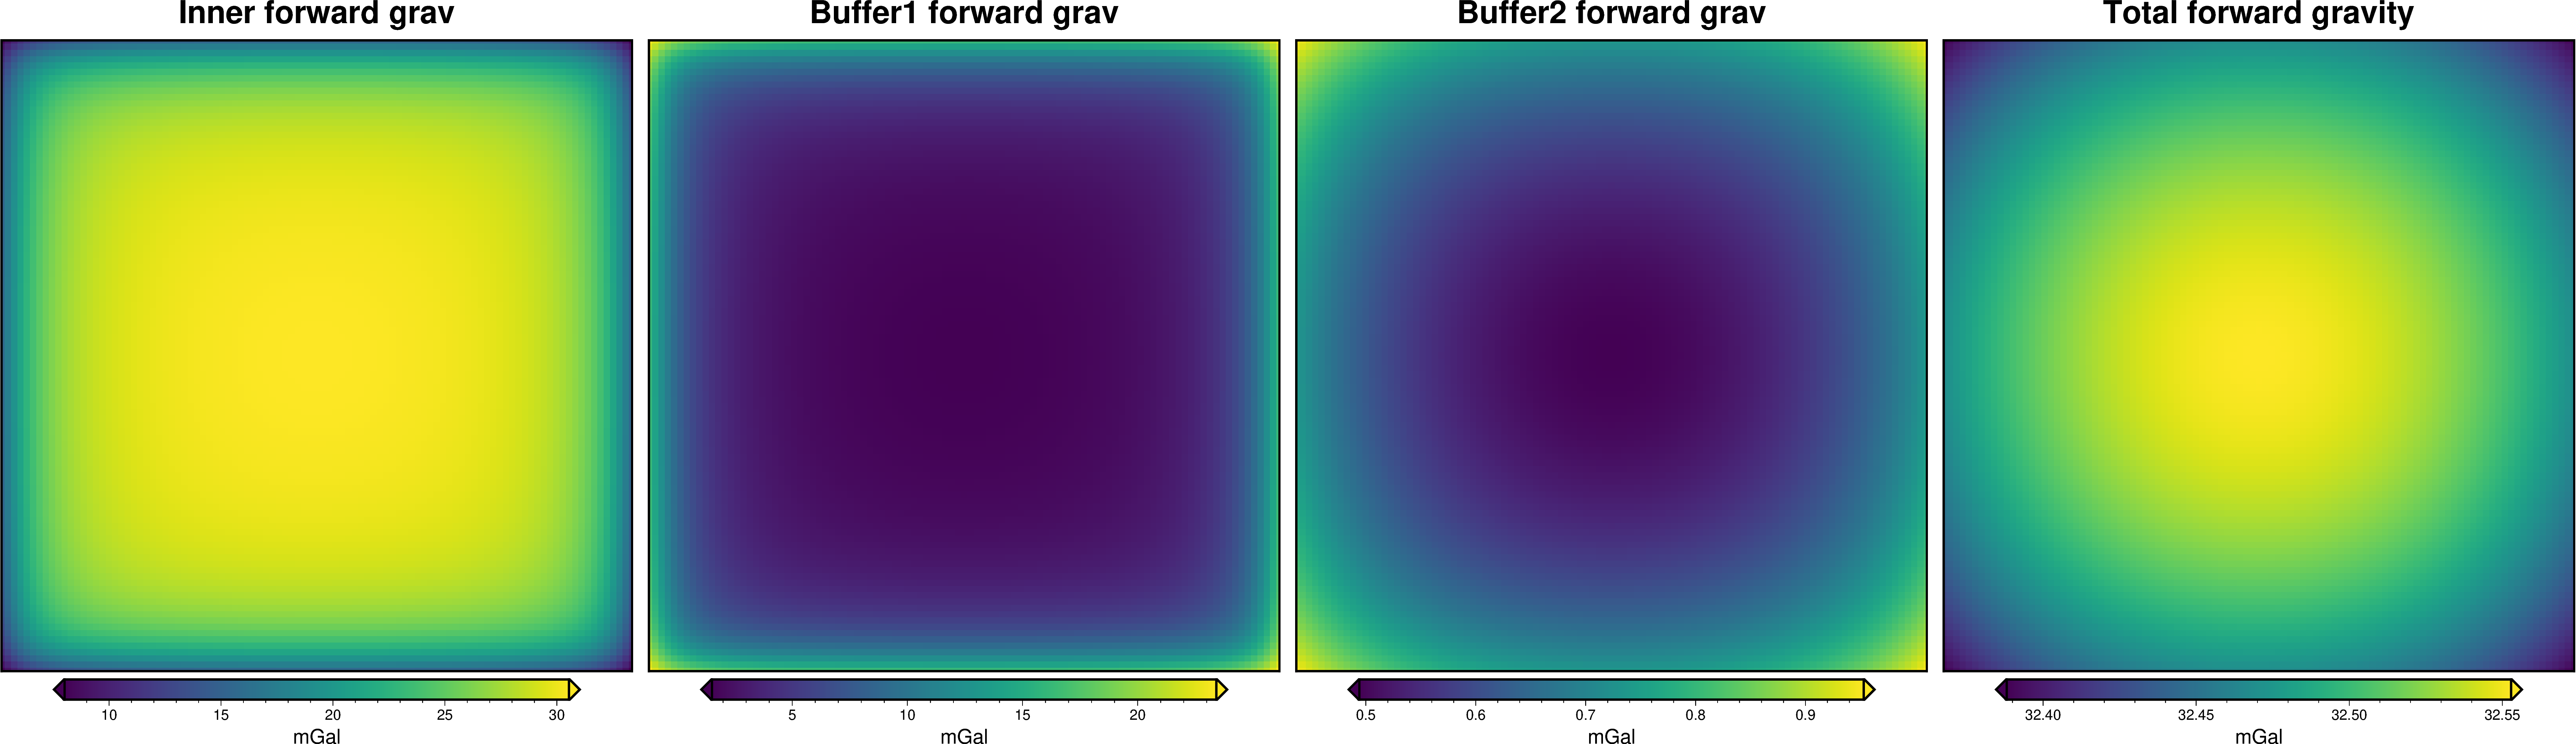

forward calculation took 24.270269870758057 secs


In [20]:
dual_buffer_forward_grav, dual_buffer_time = forward_grav_of_prismlayer(
    [inner_prisms, buffer1_prisms, buffer2_prisms],
    observation_points,
    plot=True,
    names=["Inner forward grav", "Buffer1 forward grav", "Buffer2 forward grav"],
)
print(f"forward calculation took {dual_buffer_time} secs")

## profile

grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


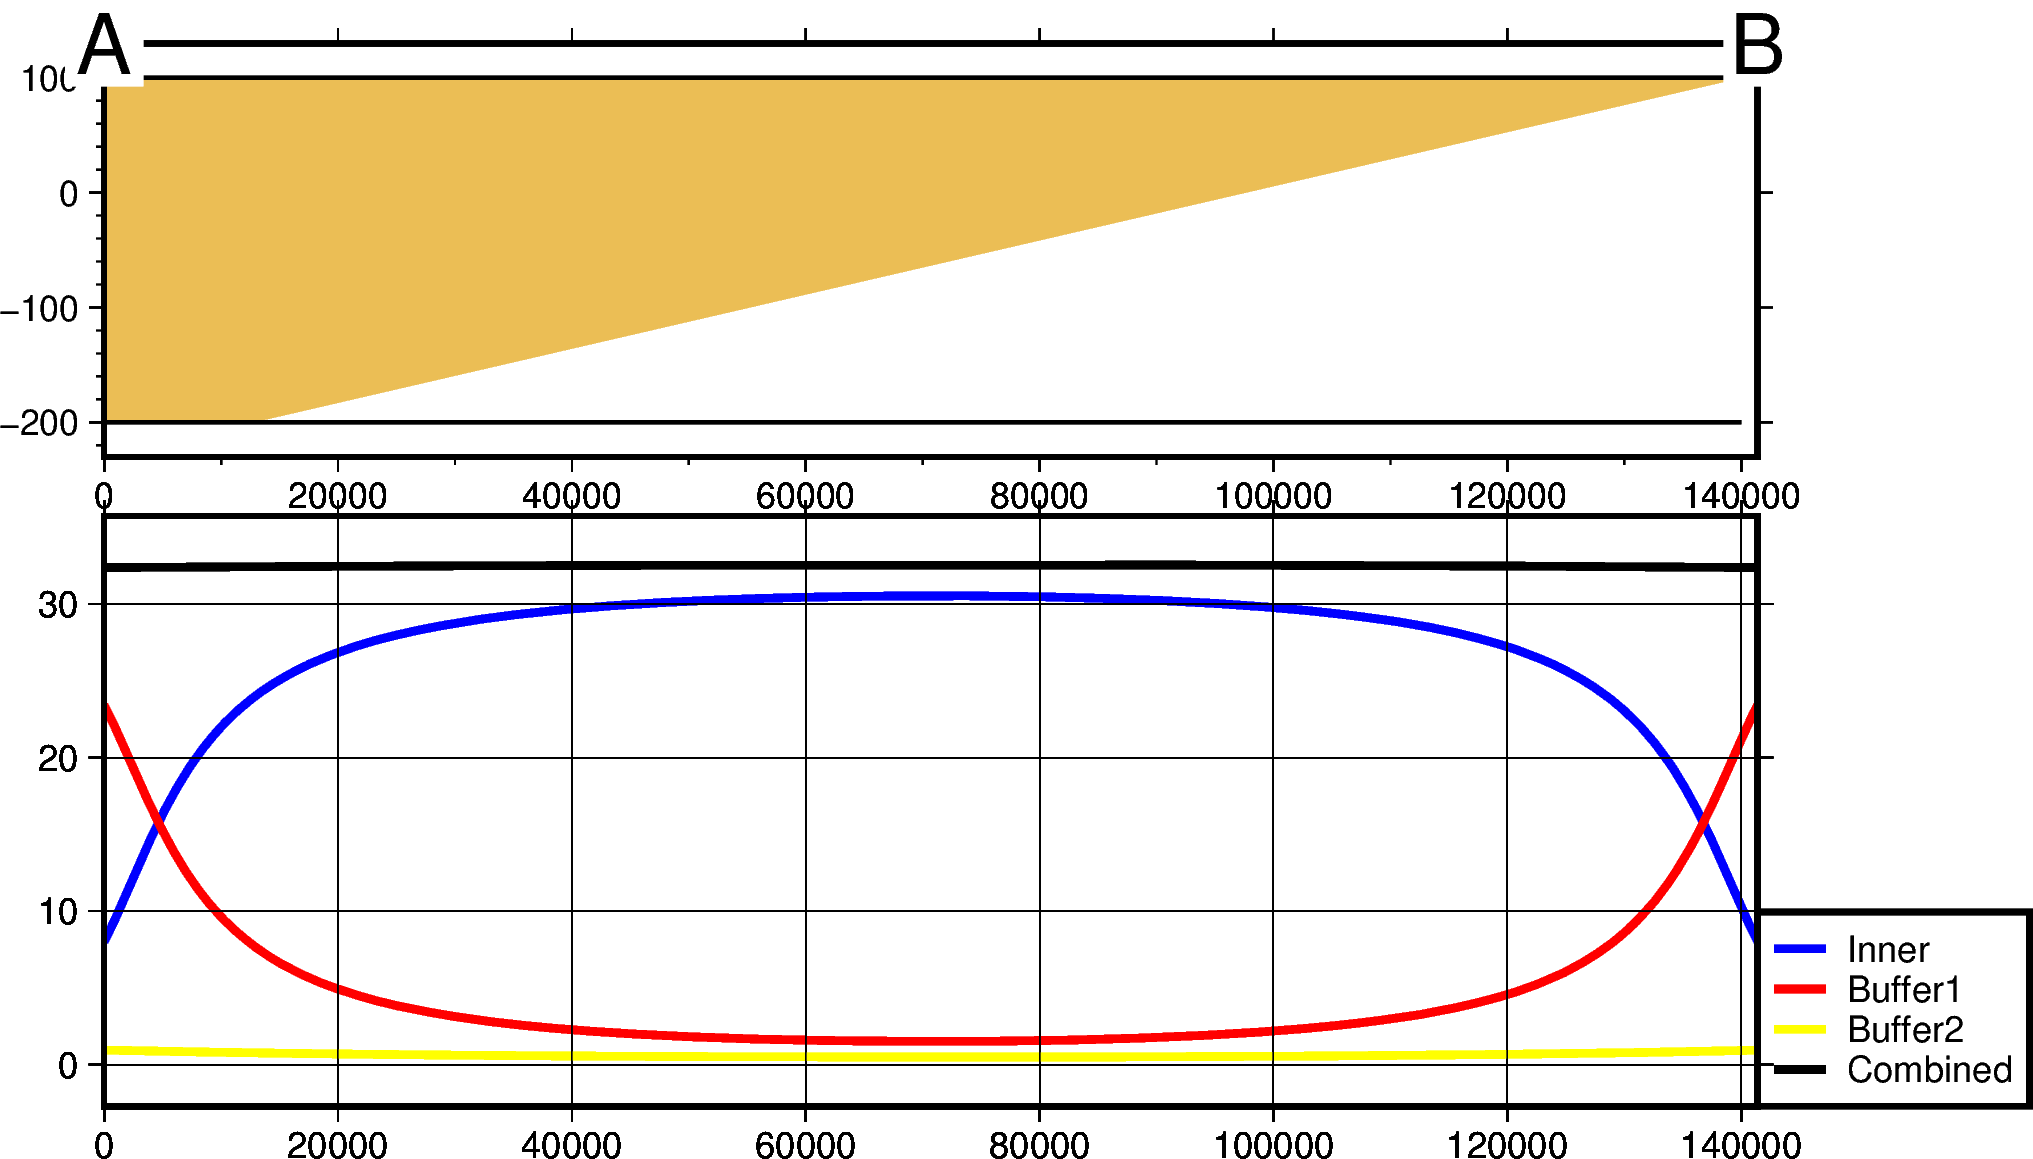

In [21]:
layers_dict = profile.make_data_dict(
    ["top", "bottom"],
    [inner_prisms.top, inner_prisms.bottom],
    ["lightbrown", "white"],
)
data_dict = profile.make_data_dict(
    ["Inner", "Buffer1", "Buffer2", "Combined"],
    [dual_buffer_forward_grav[0], 
    dual_buffer_forward_grav[1], 
    dual_buffer_forward_grav[2],
    dual_buffer_forward_grav[3]],
    ["blue", "red", "yellow","black"],
)

profile.plot_profile(
    "points",
    # start=(inner_region[0], y_mid),
    # stop=(inner_region[1], y_mid),
    start=(inner_region[0], inner_region[2]),
    stop=(inner_region[1], inner_region[3]),
    layers_dict=layers_dict,
    data_dict=data_dict,
    data_height=5,
    share_yaxis=True,
    # add_map=True,
    # map_buffer=0.7,
    # map_background=surface,
    # map_cmap="viridis",
    # coast=False,
    # inset=False,
    # gridlines=False,
)

# Compare Methods

<AxesSubplot: xlabel='type', ylabel='number_prisms'>

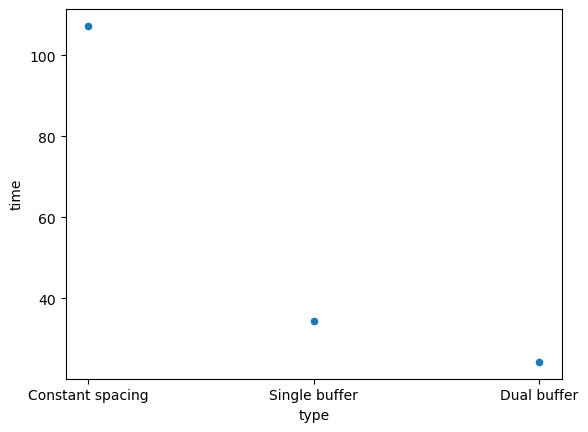

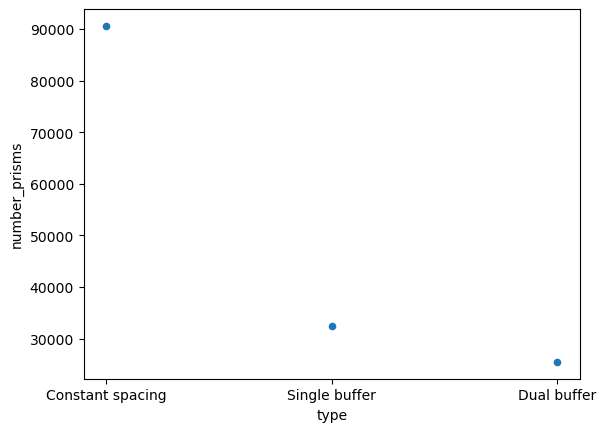

In [29]:
single_buffer_num = len(vd.grid_to_table(inner_prisms)) + \
                    len(vd.grid_to_table(buffer_prisms))
dual_buffer_num = len(vd.grid_to_table(inner_prisms)) + \
                    len(vd.grid_to_table(buffer1_prisms)) + \
                    len(vd.grid_to_table(buffer2_prisms))
df = pd.DataFrame((
    ["Constant spacing", constant_time, len(vd.grid_to_table(prisms))], 
    ["Single buffer", single_buffer_time, single_buffer_num], 
    ["Dual buffer", dual_buffer_time, dual_buffer_num],
    ),
    columns=('type', 'time', 'number_prisms'))
df.plot.scatter('type', "time")
df.plot.scatter('type', "number_prisms")

In [35]:
df.time

0    107.282571
1     34.415931
2     24.270270
Name: time, dtype: float64

In [34]:
df.time[0]/df.time[2]

4.4203287153468045

returning original grid
returning original grid
returning original grid
returning original grid
returning original grid


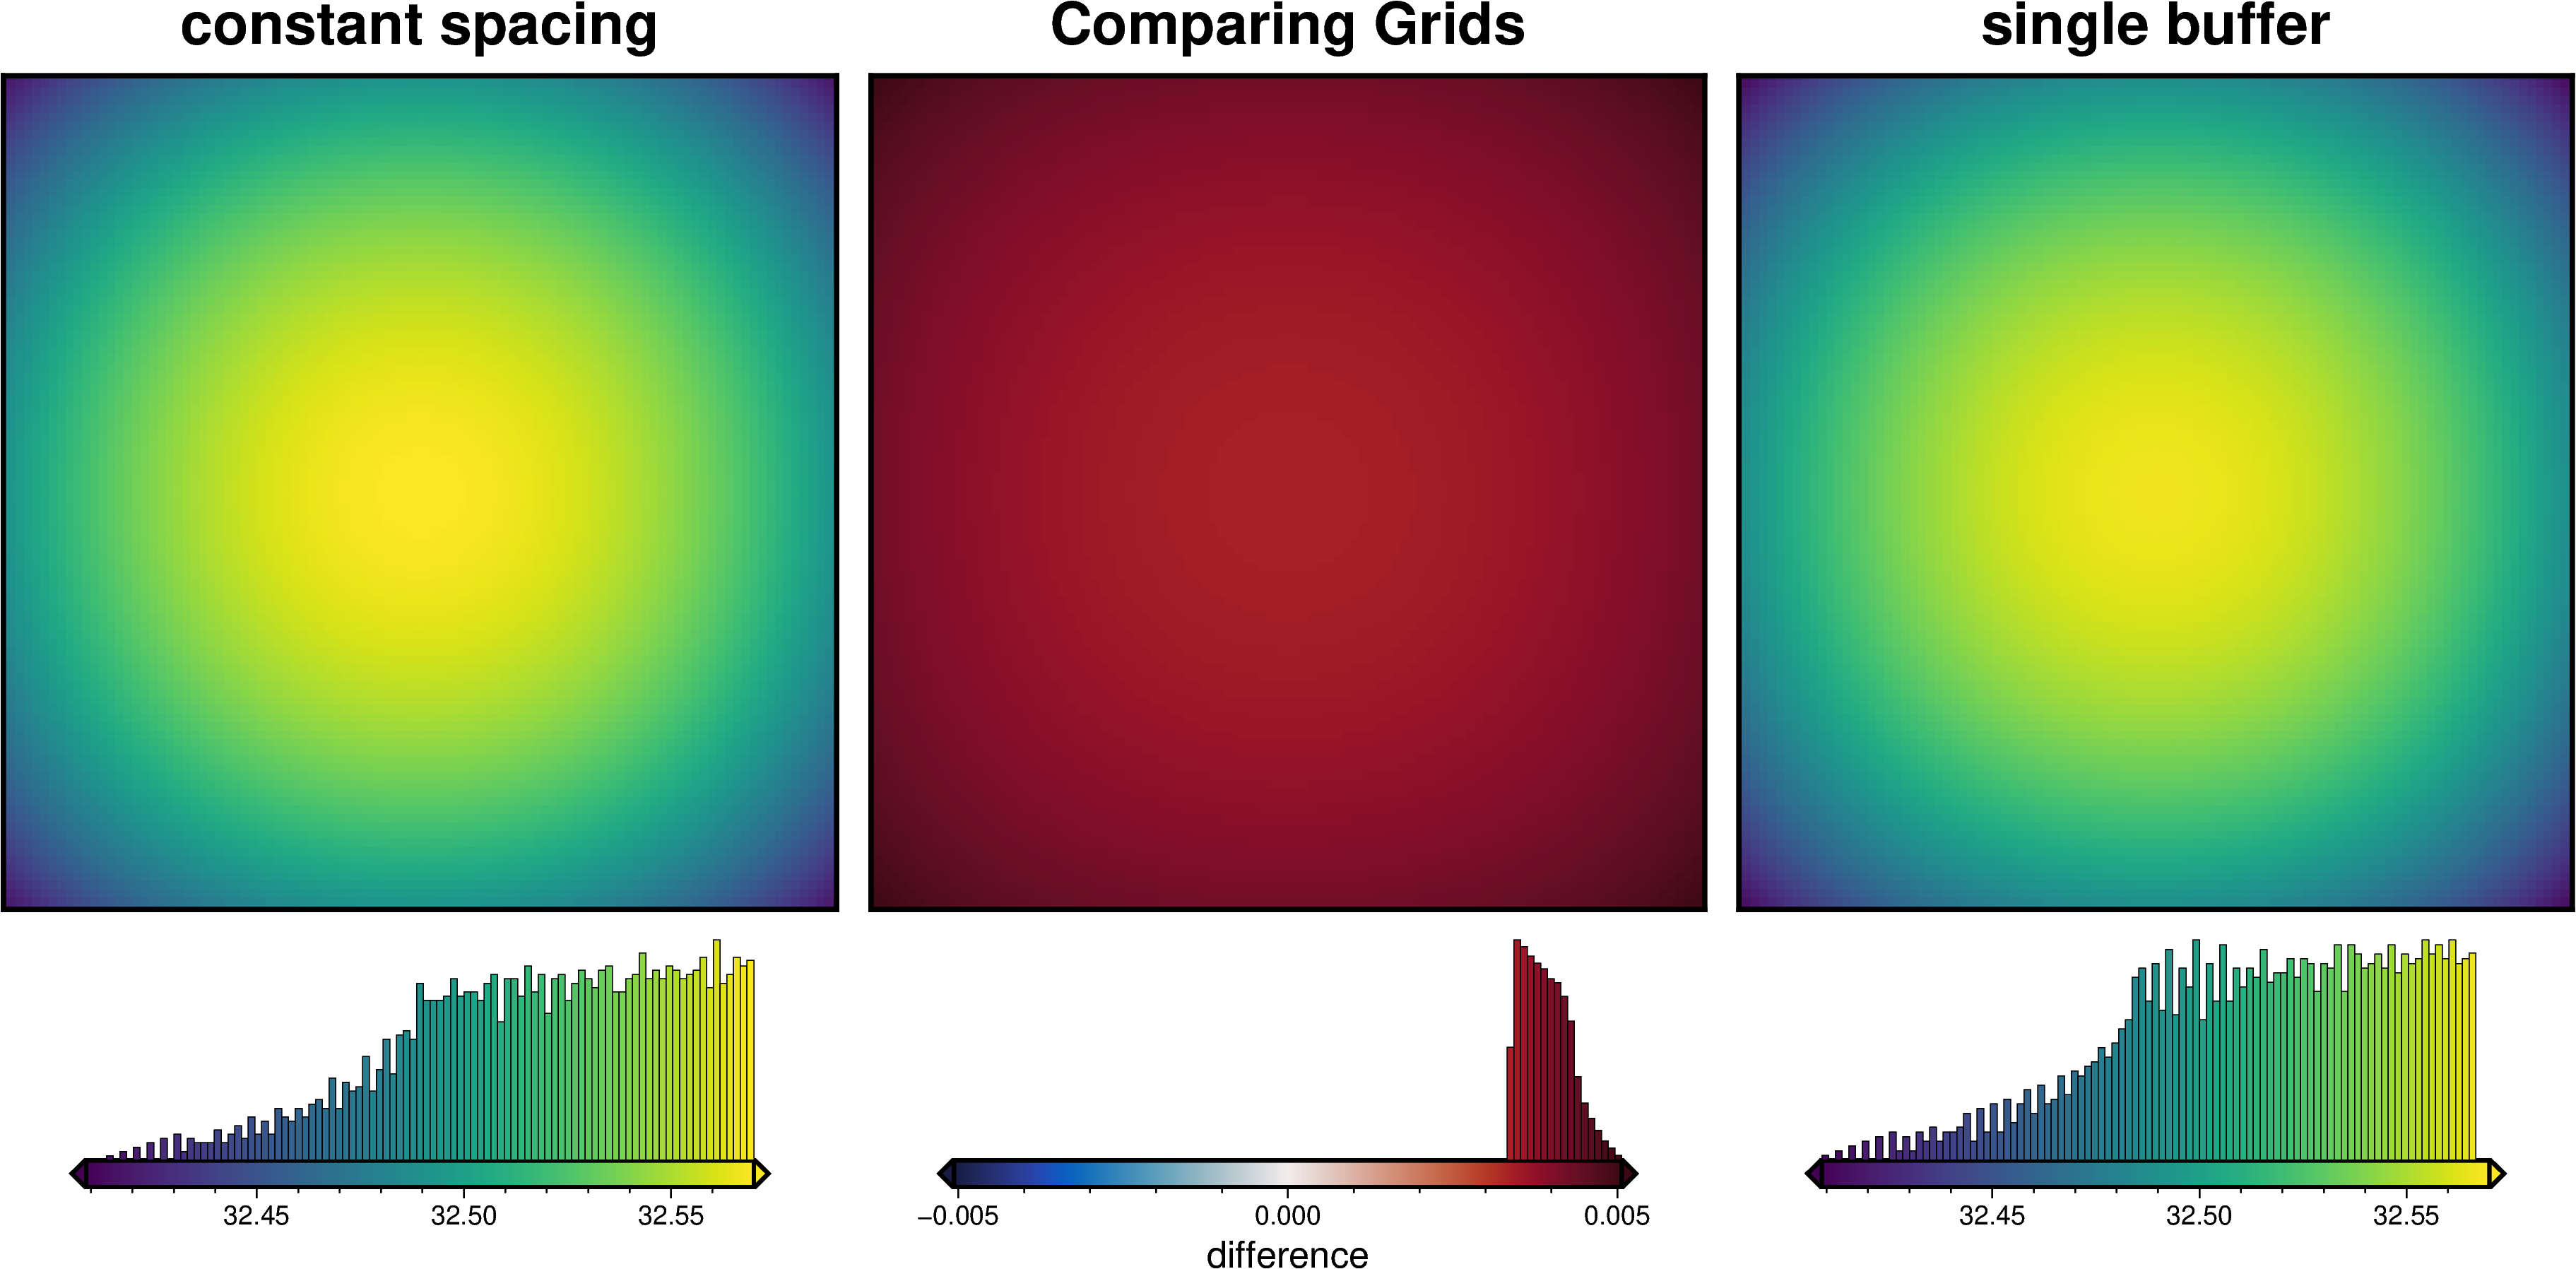

In [23]:
grids = utils.grd_compare(
    constant_forward_grav[0],
    single_buffer_forward_grav[2],
    plot=True,
    inset=False,
    grid1_name="constant spacing",
    grid2_name="single buffer",
    show_region=inner_region,
    hist=True,
)

returning original grid
returning original grid
returning original grid
returning original grid
returning original grid


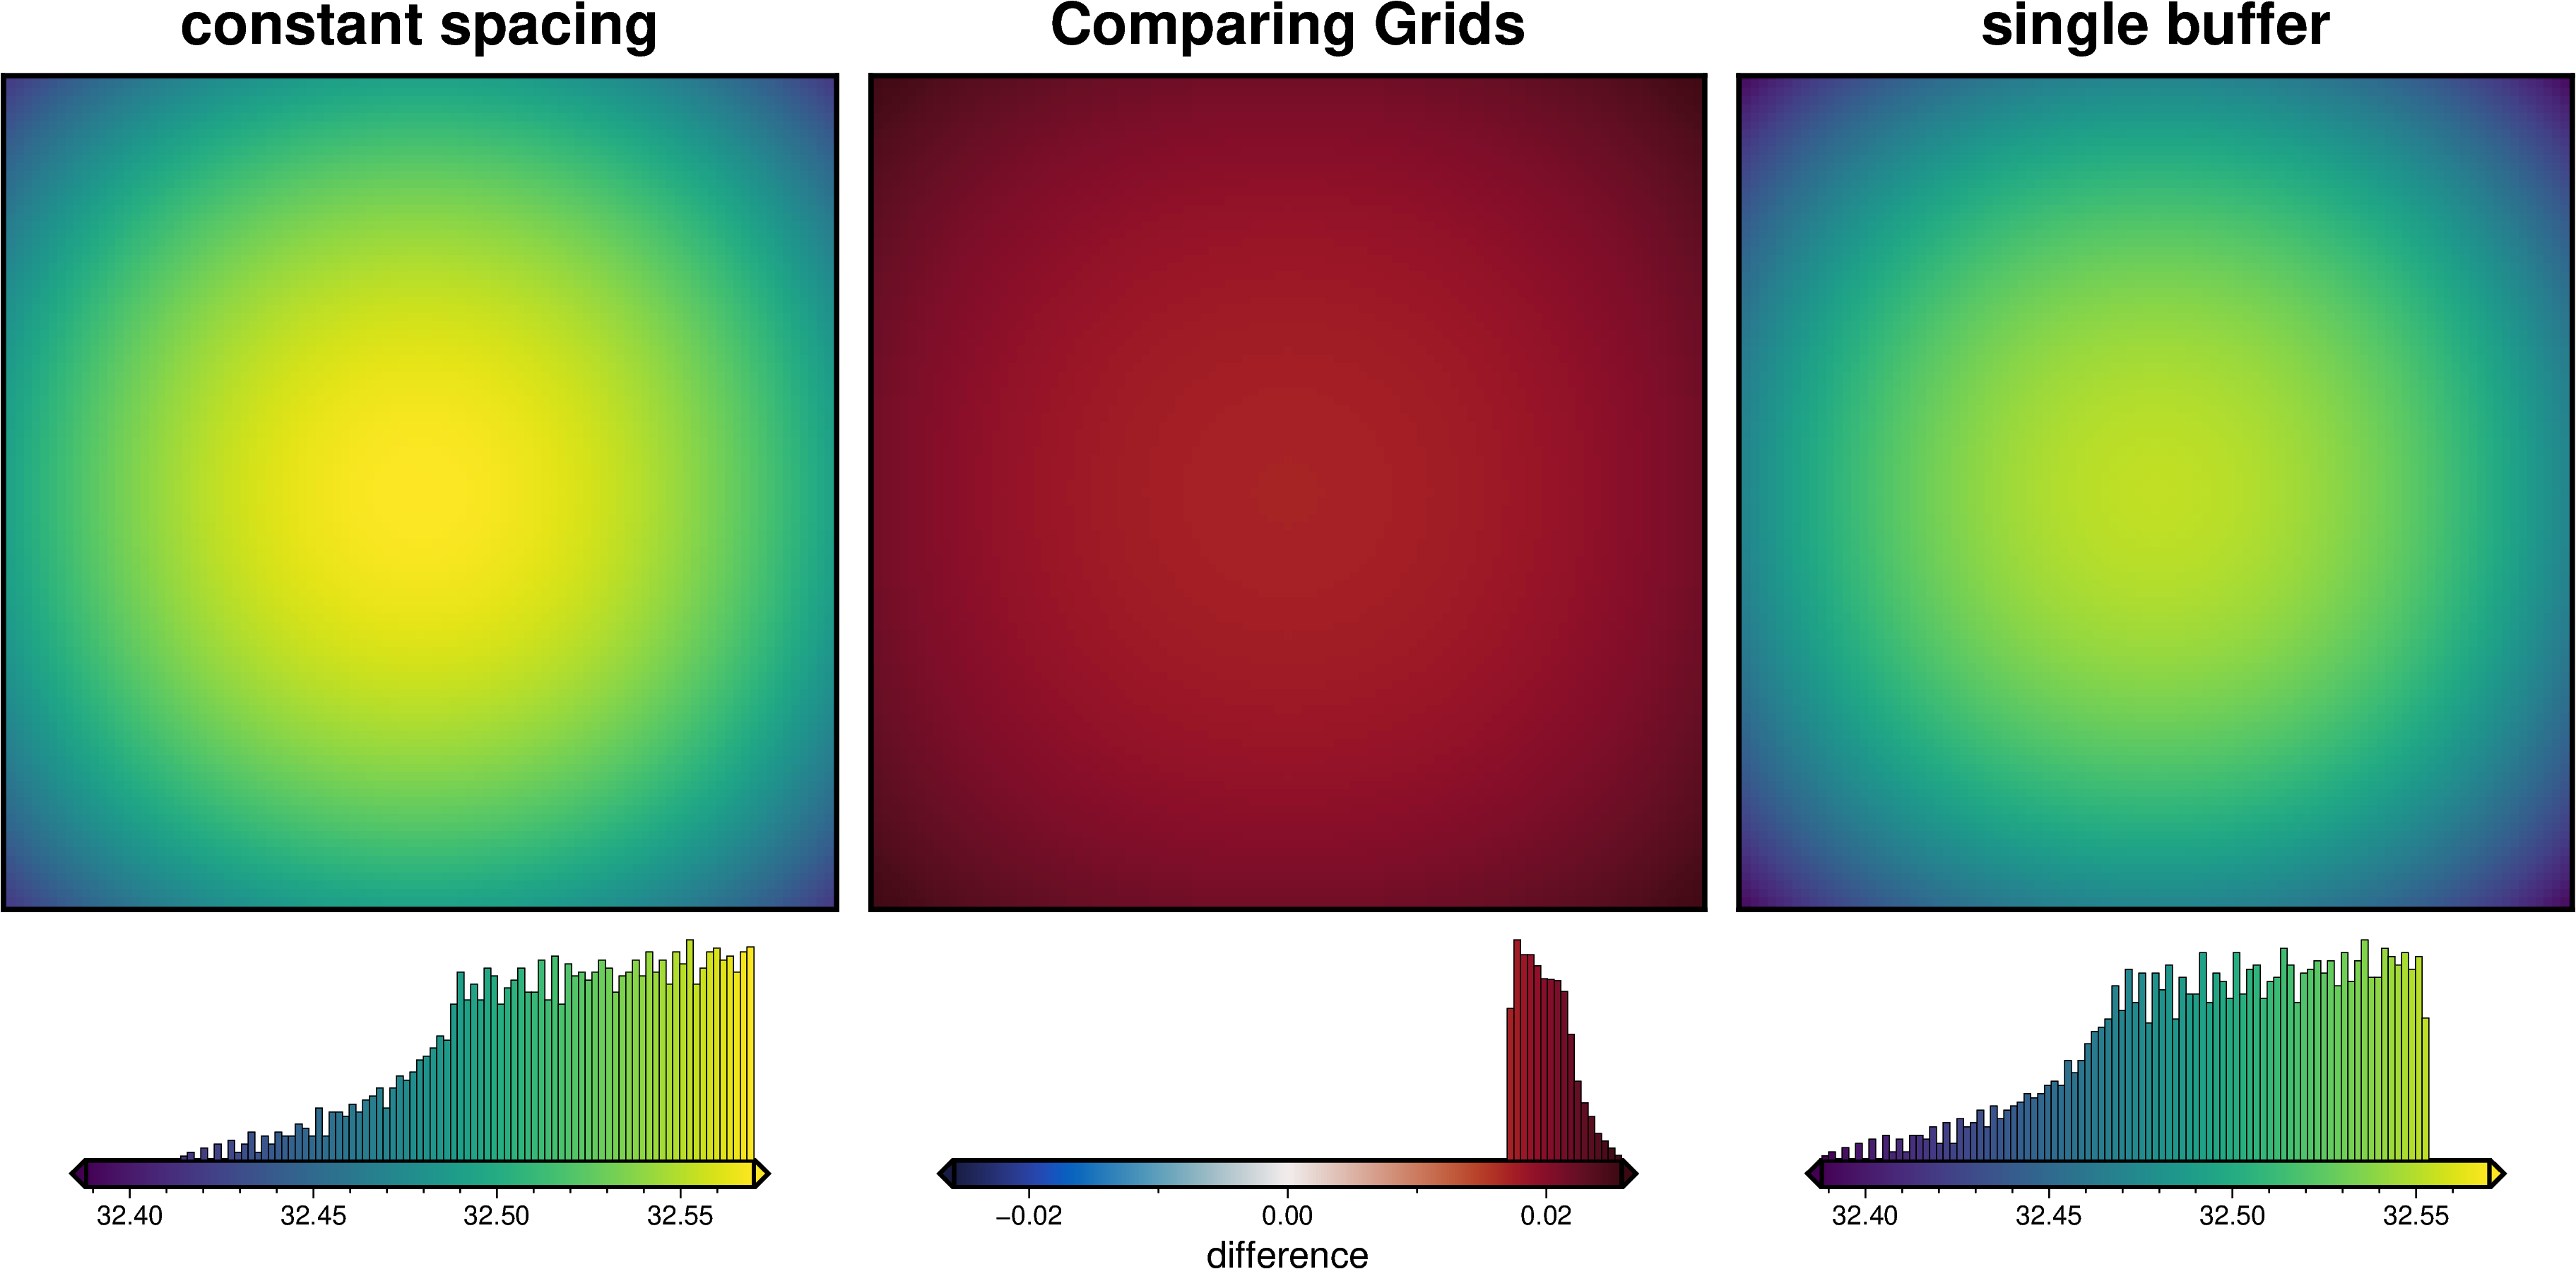

In [24]:
grids = utils.grd_compare(
    constant_forward_grav[0],
    dual_buffer_forward_grav[3],
    plot=True,
    inset=False,
    grid1_name="constant spacing",
    grid2_name="single buffer",
    show_region=inner_region,
    hist=True,
)

grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


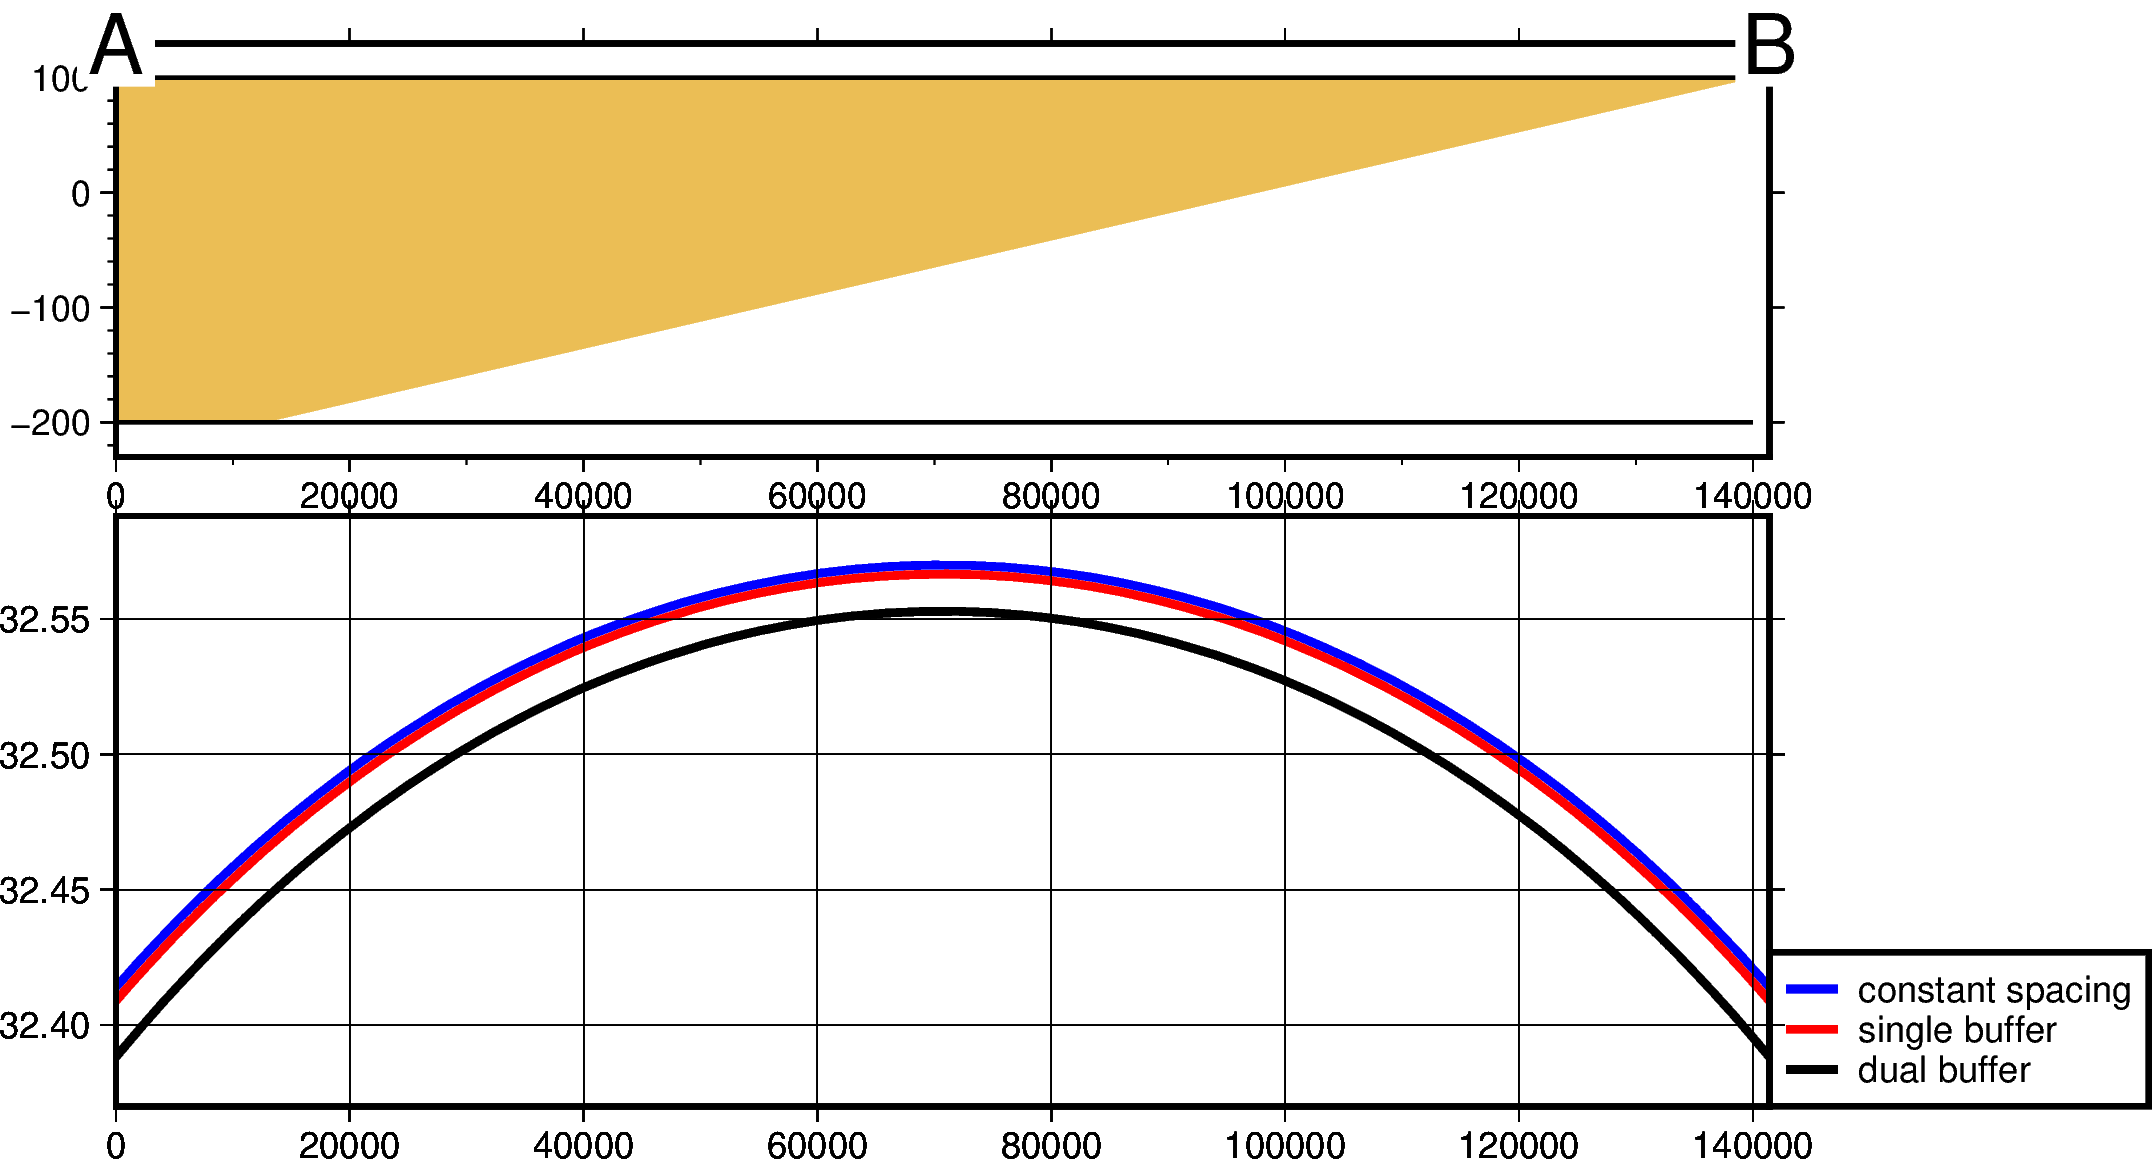

In [26]:
layers_dict = profile.make_data_dict(
    ["top", "bottom"],
    [inner_prisms.top, inner_prisms.bottom],
    ["lightbrown", "white"],
)
data_dict = profile.make_data_dict(
    ["constant spacing", "single buffer", "dual buffer"],
    [constant_forward_grav[0], single_buffer_forward_grav[2], dual_buffer_forward_grav[3]],
    ["blue", "red", "black"],
)

profile.plot_profile(
    "points",
    # start=(inner_region[0], y_mid),
    # stop=(inner_region[1], y_mid),
    start=(inner_region[0], inner_region[2]),
    stop=(inner_region[1], inner_region[3]),
    layers_dict=layers_dict,
    data_dict=data_dict,
    data_height=5,
    share_yaxis=True,
    # add_map=True,
    # map_buffer=0.7,
    # map_background=surface,
    # map_cmap="viridis",
    # coast=False,
    # inset=False,
    # gridlines=False,
)